# Starbucks Capstone Challenge
#### A capstone project as part of my Udacity Data Scientist Nanodegree Program

###  Project Overview

The objective of this project is to do a detailed analysis of the simulated data provided by Udacity (simplified version of the real Starbucks app data) that mimics customer behavior on the Starbucks rewards mobile app, along with a machine learning model that predicts whether a customer will respond to an offer sent to respective users. 

Once every few days, Starbucks sends out an offer to its users' mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. ALso, not all users receive the same offer, and that is the challenge to solve with this data set.

The goal here is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, it can be assumed the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Also a transactional data is provided that contains user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Problem Statement

Given the datasets below, the objective is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer reward, and to predict which users, who normally wouldn't make a purchase, would respond to a sent offer and make a purchase through it. This can be done by first answering a below questions:

1.  What percentage of Customers view offers and find out their characteristics?
2.  What percentage of Customers respond to offers and what percentage complete the offer after viewing it?
3.  How much do adevertisements contribute in user transactions?
4.  Predict whether a Customer will respond to an offer or not using demographics and offer reward data?

## Metrics

The F1 score is chosen to be the metric as it defines the harmonic mean of precision and recall taking both metrics into account.

<img src="./screenshots/precision.png" width="350"/>
<img src="./screenshots/f1score.png" width="250"/>

# Data Understanding

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import time

%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


### Read the Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Lets understand each of these data sets in detail.


In [2]:
# read data from json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Understanding offer data from portfolio data set


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)


Following are 3 different offer types available in the dataset.
- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products


In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print("No of rows in portfolio dataset are: {} and no of columns are: {} ".format( portfolio.shape[0], portfolio.shape[1] ))

No of rows in portfolio dataset are: 10 and no of columns are: 6 


In [5]:
# check detailed info about portfolio data for no of columns, datatypes and null values
portfolio.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
#check for missing values
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

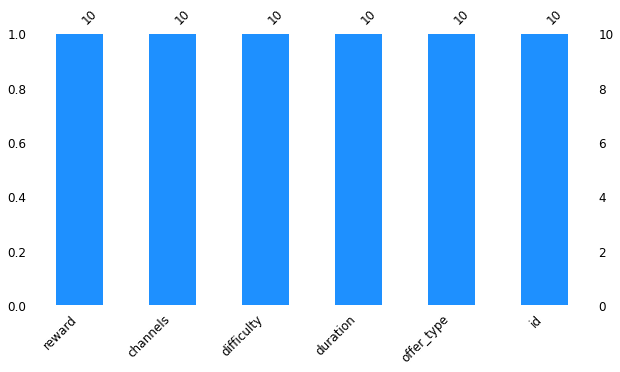

In [7]:
missingno.bar(portfolio, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [8]:
#Columns with missing values
print("Column names with missing values: \n", portfolio.columns[portfolio.isnull().sum(axis=0)>0].values)

#Total no of missing values in df_listings dataset
print("Total number of missing values are:",portfolio.isnull().sum().sum())

Column names with missing values: 
 []
Total number of missing values are: 0


In [9]:
# Check counts for each offer type
portfolio.offer_type.value_counts()
#portfolio.groupby('offer_type')['id'].count()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

#### Understanding Demographic data from profile data set

Demographic data for customers is provided in the `profile` dataset. The schema and variables are as follows: 

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income


In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
print("No of rows in profile dataset are: {} and no of columns are: {} ".format(  profile.shape[0], profile.shape[1]  ))

No of rows in profile dataset are: 17000 and no of columns are: 5 


In [12]:
# check detailed info about profile data for no of columns, datatypes and null values
profile.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
#check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

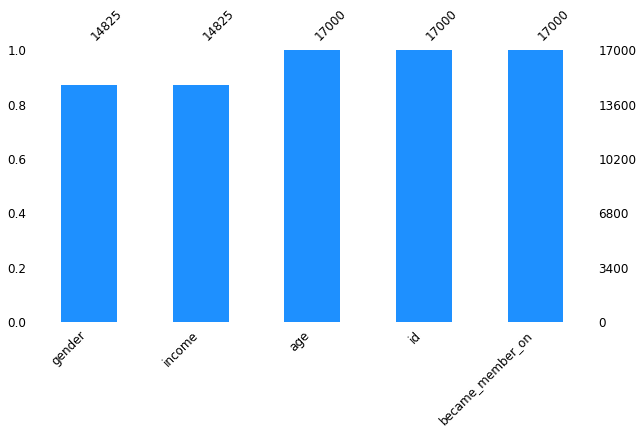

In [14]:
missingno.bar(profile, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [15]:
#Columns with missing values
print("Column names with missing values: \n", profile.columns[profile.isnull().sum(axis=0)>0].values)

#Total no of missing values in profile dataset
print("Total number of missing values are:", profile.isnull().sum().sum())

Column names with missing values: 
 ['gender' 'income']
Total number of missing values are: 4350


In [16]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

#### Understanding transcript data set

The schema for the transactional data is as follows:

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
print("No of rows in transcript dataset are: {} and no of columns are: {} ".format(  transcript.shape[0], transcript.shape[1]  ))

No of rows in transcript dataset are: 306534 and no of columns are: 4 


In [19]:
# check detailed info about transcript data for no of columns, datatypes and null values
transcript.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [20]:
#check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

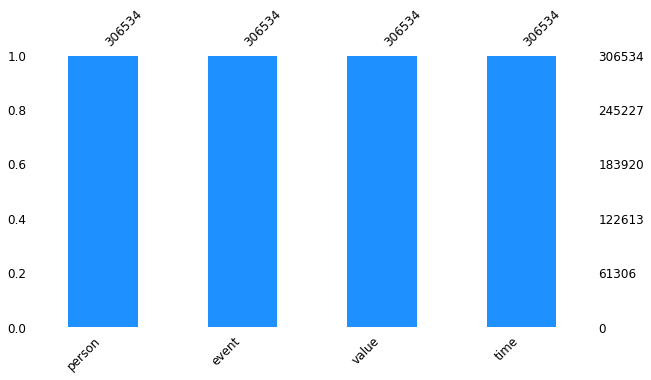

In [21]:
missingno.bar(transcript, color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [22]:
#Columns with missing values
print("Column names with missing values: \n", transcript.columns[transcript.isnull().sum(axis=0)>0].values)

#Total no of missing values in transcript dataset
print("Total number of missing values are:", transcript.isnull().sum().sum())

Column names with missing values: 
 []
Total number of missing values are: 0


In [23]:
# Check counts for each event type
transcript.event.value_counts()
#transcript.groupby('event').count()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

There are 4 unique events are available in the data set i.e. **transaction,offer received, offer viewed, offer completed**

In [24]:
#check number of unique people represented
transcript['person'].nunique()

17000

Number of people in transcript data set are the same as the number of people in the Demographics Data. This would be easy to combine the datasets 

# Data Preparation

Now that we understood the data sets, lets proceed to the next stage i.e. data preparation/data wrangling of all data sets.

#### Data Wrangling of Portfolio data set

**Handling of categorical variables**

In [25]:
# create dummy columns for categorical variables

# convert the offer_type column to dummy variables
offertype_dummies = pd.get_dummies(portfolio.offer_type,prefix='is')

# convert the channel column to dummy variables
channel_dummies = portfolio.channels.apply(lambda x: str(x)[1:-1].replace('\'','')).str.get_dummies(sep = ', ')
# Remove white spaces from columns
channel_dummies.columns = channel_dummies.columns.str.strip()

# Concatinate new columns to portofolio and remove channels and offer_type columns
portfolio = pd.concat([portfolio,offertype_dummies,channel_dummies],axis=1).drop(['channels'],axis=1)

portfolio.head()

,reward,difficulty,duration,offer_type,id,is_bogo,is_discount,is_informational,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,0,0,1


#### Data Wrangling of profile data set

In [26]:
# convert the became_member_on column to timestamp
profile.became_member_on = pd.to_datetime(profile.became_member_on,format='%Y%m%d')

# Fill null values in income column with mean of incomes
# profile.income = profile.income.fillna(profile.income.mean())

# Replace the None values of gender column to 'O' to classify as other types
profile.gender = profile.gender.apply(lambda x: 'O' if x is None else x)

# Convert the gender column to dummy variables
gender_dummies = pd.get_dummies(profile.gender,prefix='gender')

# Concatinate new columns to profile and remove gender column
profile = pd.concat([profile,gender_dummies],axis = 1)
profile.head()

,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0
4,O,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,1


#### Data Wrangling of transcript data set

In [27]:
# convert the event column to dummy variables
event_dummies = pd.get_dummies(transcript.event)

# Concatenate the event dummies dataframe with transcript dataframe
transcript = pd.concat([transcript,event_dummies],axis = 1)

# Generate offer_id column to hold the offer id of the value column if any, otherwise it will have a nan
transcript['offer_id'] = transcript.value.apply(lambda x: x['offer id'] if 'offer id' in x else\
                                                x['offer_id'] if 'offer_id' in x else np.nan)

# Generate reward_value column to hold the reward value of the value column if any, otherwise it will have a zero
transcript['reward_given'] = transcript.value.apply(lambda x: x['reward'] if 'reward' in x else 0)

# Generate amount column to hold the transaction amount of the value column if any, otherwise it will have a zero
transcript['amount'] = transcript.value.apply(lambda x: x['amount'] if 'amount' in x else 0)


# # Remove value and event columns
transcript.drop(['value','event'],axis=1,inplace=True)

# Remove duplicated rows
transcript.drop_duplicates(inplace=True,ignore_index=True)

transcript.head()

,person,time,offer completed,offer received,offer viewed,transaction,offer_id,reward_given,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0.0


# Data Exploration

Let's perform some data exploration using various visualization techniques to gain insights about the datas ets. 

#### Find out the distribution of our users based on their age and gender.

In [28]:
#setting the global color for categorical visualizations 
base = sns.color_palette("husl")[4]

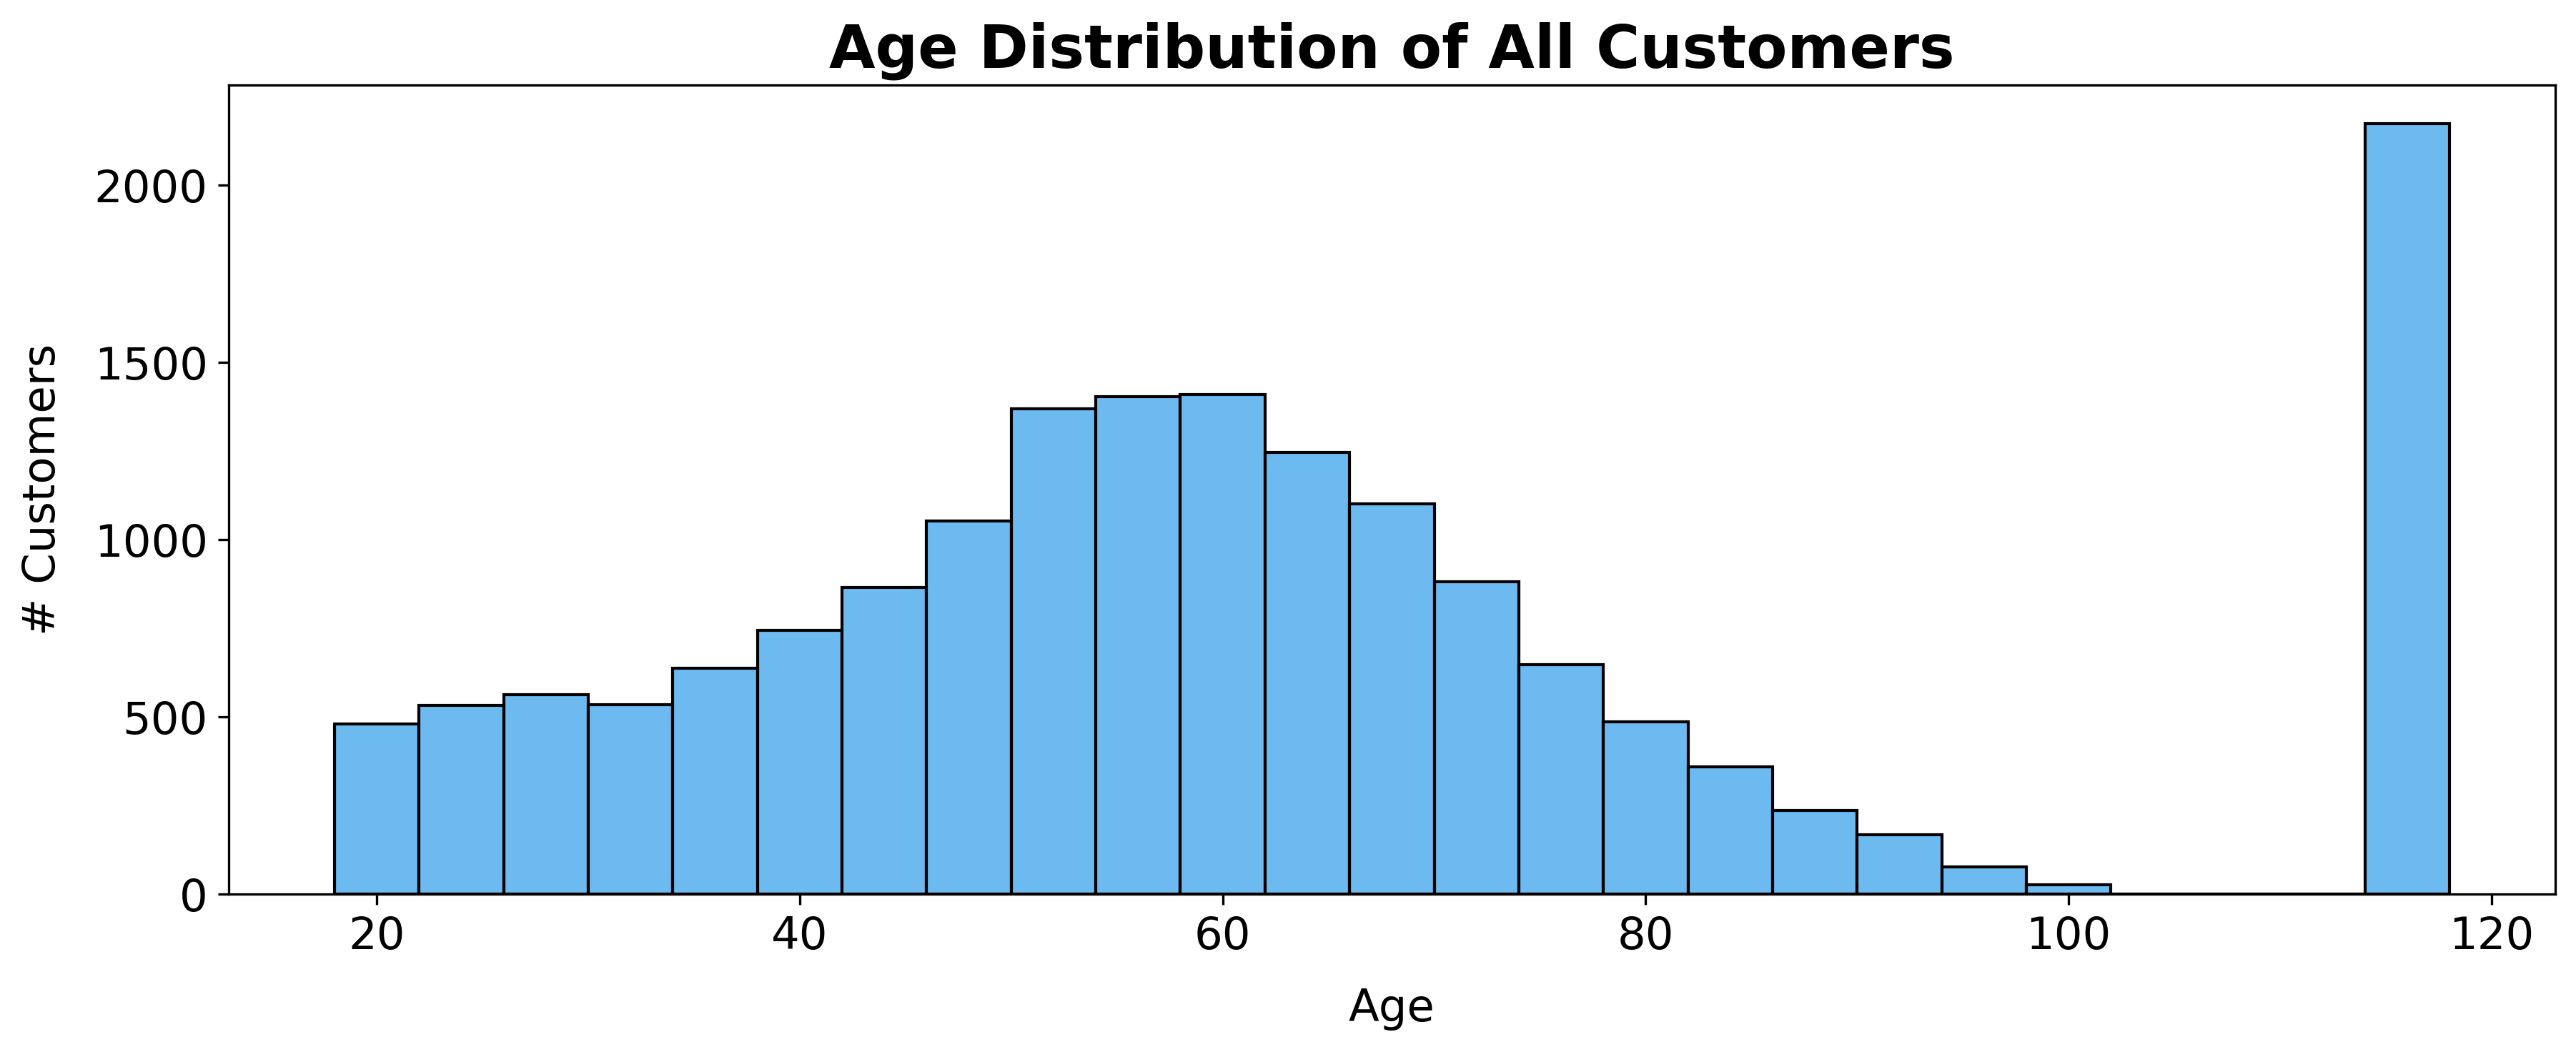

In [29]:
#Distribution of age column
plt.figure(figsize = [14,5],  dpi=300 )
sns.histplot(profile.age, bins = 30, binwidth =4, color = base)
plt.xlabel('Age',fontsize=15,labelpad=10)
plt.ylabel('# Customers',fontsize=15,labelpad=10);
plt.title('Age Distribution of All Customers',fontsize=20, weight='bold')
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.savefig('./screenshots/1_Age_Distribution_All_Customers.png', dpi=600, bbox_inches ='tight')
plt.show()

There is a big spike around 120 level. So it's evident from the chart that the distribution is more for customers with age around 120 i.e. more number of customer entries are there in the data set with age around 120 years.

This is because there are  same users who selected their gender as O (which is other than male or female) and they all have an exact age of 118. 

In [30]:
profile[profile['age']==118].gender.value_counts()

O    2175
Name: gender, dtype: int64

Income for those people are also have Null entries in the dataset as shown below.

In [31]:
profile[profile['age']==118].income.value_counts()

Series([], Name: income, dtype: int64)

In [32]:
profile[profile['age']==118].shape[0] == profile[profile['income'].isnull()].shape[0]

True

In [33]:
profile[(profile['age']==118) & (profile['income'].isnull()) & (profile['gender_O'] ==1)].shape[0]

2175

It's concluded that there are 2175 users of age 118 years who don't prefer to share their personal info like gender and income details. So let's separate those users to a new data frame. Add a new column that identifies the user those who provided any info with value as 0 else 1

In [34]:
profile['user_info_provided'] = profile.apply(lambda x: 1 if x['age']==118   else 0,axis=1)
profile.head()

,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O,user_info_provided
0,O,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,0,1,1
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,0
2,O,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,0,1,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,0
4,O,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,0,1,1


**Customer Distribution based on user info provided**

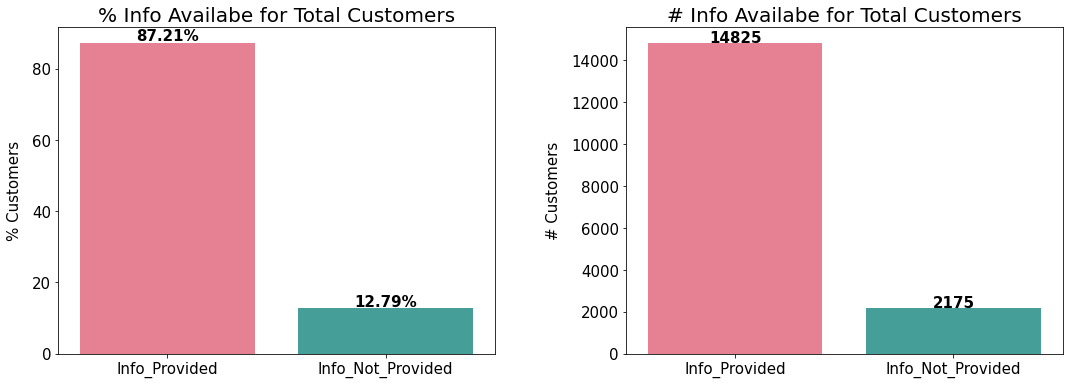

In [35]:
plt.figure(figsize = [18,6])
plt.subplots_adjust(wspace = 0.3)
plt.subplots_adjust(hspace = 0.3)
#plt.tight_layout(pad =5)

plt.subplot(1,2,1)
x = profile.user_info_provided.value_counts().index
y = round(profile.user_info_provided.value_counts()/profile.shape[0]*100, 2)
sns.barplot(x=x, y=y, order =y.sort_values(ascending=False).index, palette="husl", alpha=1)
plt.xticks(ticks = [0,1], labels = ['Info_Provided','Info_Not_Provided'], rotation = 0,fontsize=15)
plt.xlabel('');
plt.yticks(fontsize=15)
plt.ylabel('% Customers',fontsize=15,labelpad=10,rotation = 90)
plt.title('% Info Availabe for Total Customers', fontsize=20)

for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+4, str(count)+"%", ha = 'center', va ='top', fontsize = 15, rotation = 0, color = 'black', weight='bold')


plt.subplot(1,2,2)
sns.countplot(data = profile, x = 'user_info_provided', palette="husl");
plt.xticks(ticks = [0,1], labels = ['Info_Provided','Info_Not_Provided'], rotation = 0,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('# Customers',fontsize=15,labelpad=10,rotation = 90)
plt.xlabel('');
plt.title('# Info Availabe for Total Customers',fontsize=20)
y = profile.user_info_provided.value_counts()

for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+630, count, ha = 'center', va ='top', fontsize = 15, rotation = 0, color = 'black', weight='bold')
plt.savefig('./screenshots/2_Customer_Distribution_Info_Provided.png', dpi=600, bbox_inches ='tight')
plt.show()

Let's repeat the exploration of the age distribution by excluding the users who didn't provide any user info.

#### Distribution of age for the customers for which user info is available

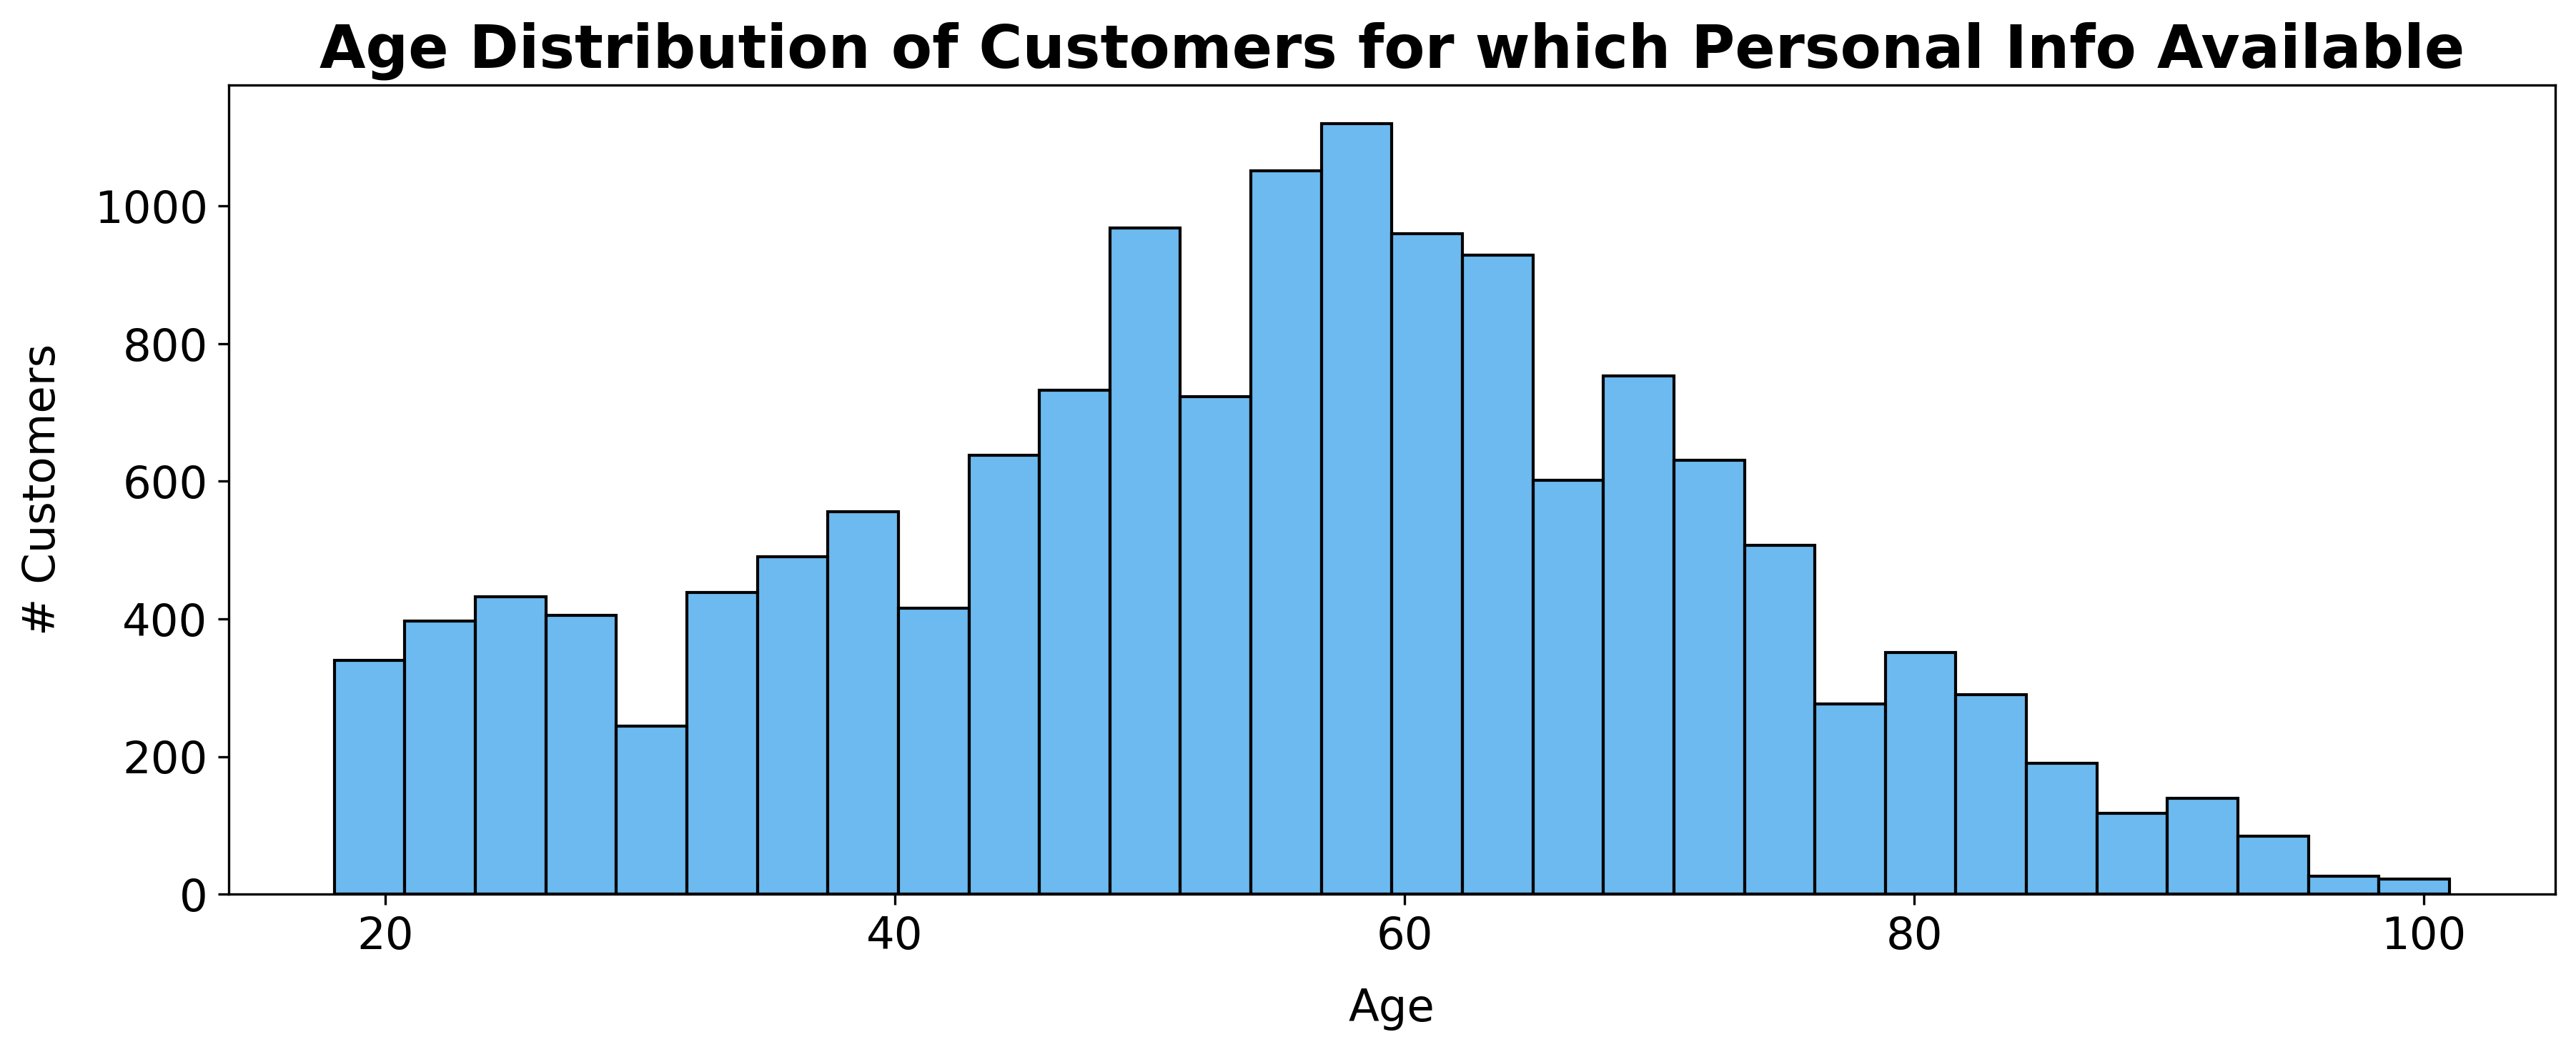

In [36]:
#Distribution of age excluding the users who didn't provide any info
plt.figure(figsize = [14,5],  dpi=300 )
age_dist = profile[profile.user_info_provided==0]['age']
sns.histplot(age_dist, bins = 30, color = base);
plt.xlabel('Age',fontsize=15,labelpad=10)
plt.ylabel('# Customers',fontsize=15,labelpad=10);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.title('Age Distribution of Customers for which Personal Info Available',fontsize=20, weight='bold')
plt.savefig('./screenshots/3_Age_Distribution_Without_User_Info.png', dpi=600, bbox_inches ='tight')
plt.show()

From the above visualization though for all customers, user info is available, majority of customers in the dataset are in the groups of late 50's or early 60's, and no of customers decreases as we move away from the peak i.e. age after 65 years.

Next lets look at the  **gender distribution by filtering out the customers those who didn't provide any personal info.**

In [37]:
profile[profile.user_info_provided==0][['gender_M','gender_F','gender_O']].shape[0]

14825

In [38]:
profile[profile.user_info_provided==0][['gender_M','gender_F','gender_O']].sum()

gender_M    8484
gender_F    6129
gender_O     212
dtype: int64

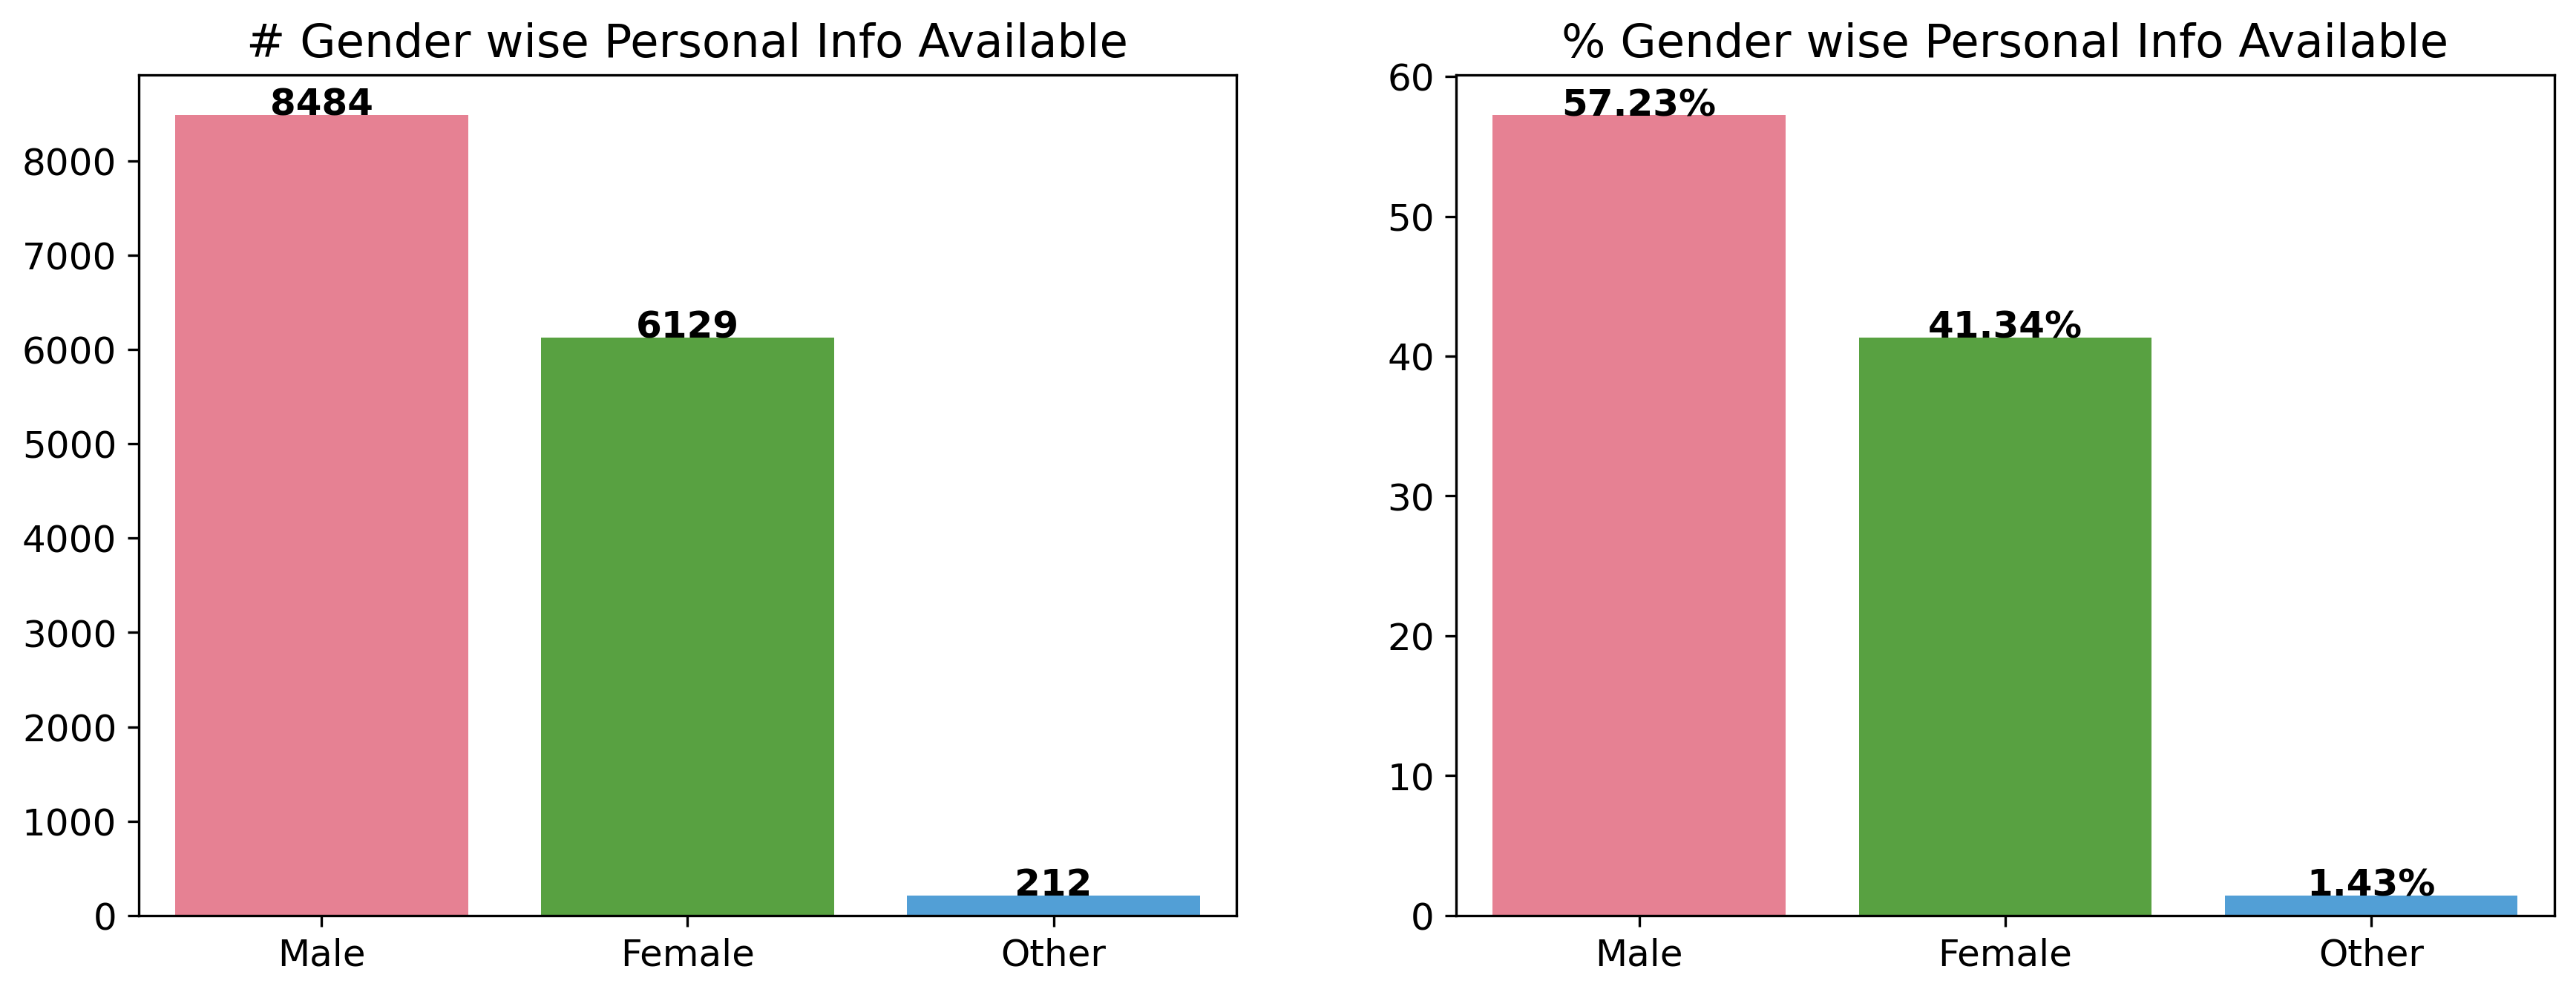

In [39]:
# Gender distribution for customers who provided personal info by filtering the customers who didn't provide any personal info.
x = profile[profile.user_info_provided==0][['gender_M','gender_F','gender_O']].sum().index
y = profile[profile.user_info_provided==0][['gender_M','gender_F','gender_O']].sum()

plt.figure(figsize = [14,5],  dpi=300 )
plt.subplot(1,2,1)
sns.barplot(x=x, y=y, order =y.sort_values(ascending=False).index, palette="husl", alpha=1)

plt.xticks(ticks = [0,1,2], labels = ['Male','Female','Other'],rotation = 0,fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('')
plt.title('# Gender wise Personal Info Available', fontsize =15)
for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+300, count, ha = 'center', va ='top', fontsize = 12, rotation = 0, color = 'black', weight='bold')


plt.subplot(1,2,2)
y = round(profile[profile.user_info_provided==0][['gender_M','gender_F','gender_O']].sum()/profile[profile.user_info_provided==0][['gender_M','gender_F','gender_O']].shape[0]*100, 2)
sns.barplot(x=x, y=y, order =y.sort_values(ascending=False).index, palette="husl", alpha=1)
plt.xticks(ticks = [0,1,2], labels = ['Male','Female','Other'],rotation = 0,fontsize=12)
plt.xlabel('')
plt.yticks(fontsize=12)
plt.title('% Gender wise Personal Info Available', fontsize =15)
for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+2, str(count)+"%", ha = 'center', va ='top', fontsize = 12, rotation = 0, color = 'black', weight='bold')
    
plt.savefig('./screenshots/4_Genders_With_Personal_Info_Available.png', dpi=600, bbox_inches ='tight')
plt.show() 

After filtering out the customers who have not provided any personal info, its observed that there are 8484 male customers which is 57.23% of the total 
provided personal info. And less than 16% Female customers than Males have provided personal info and other categories provided 1.43%.

#### Now Let's look at the distribution of user incomes for customers who provided personal infos.

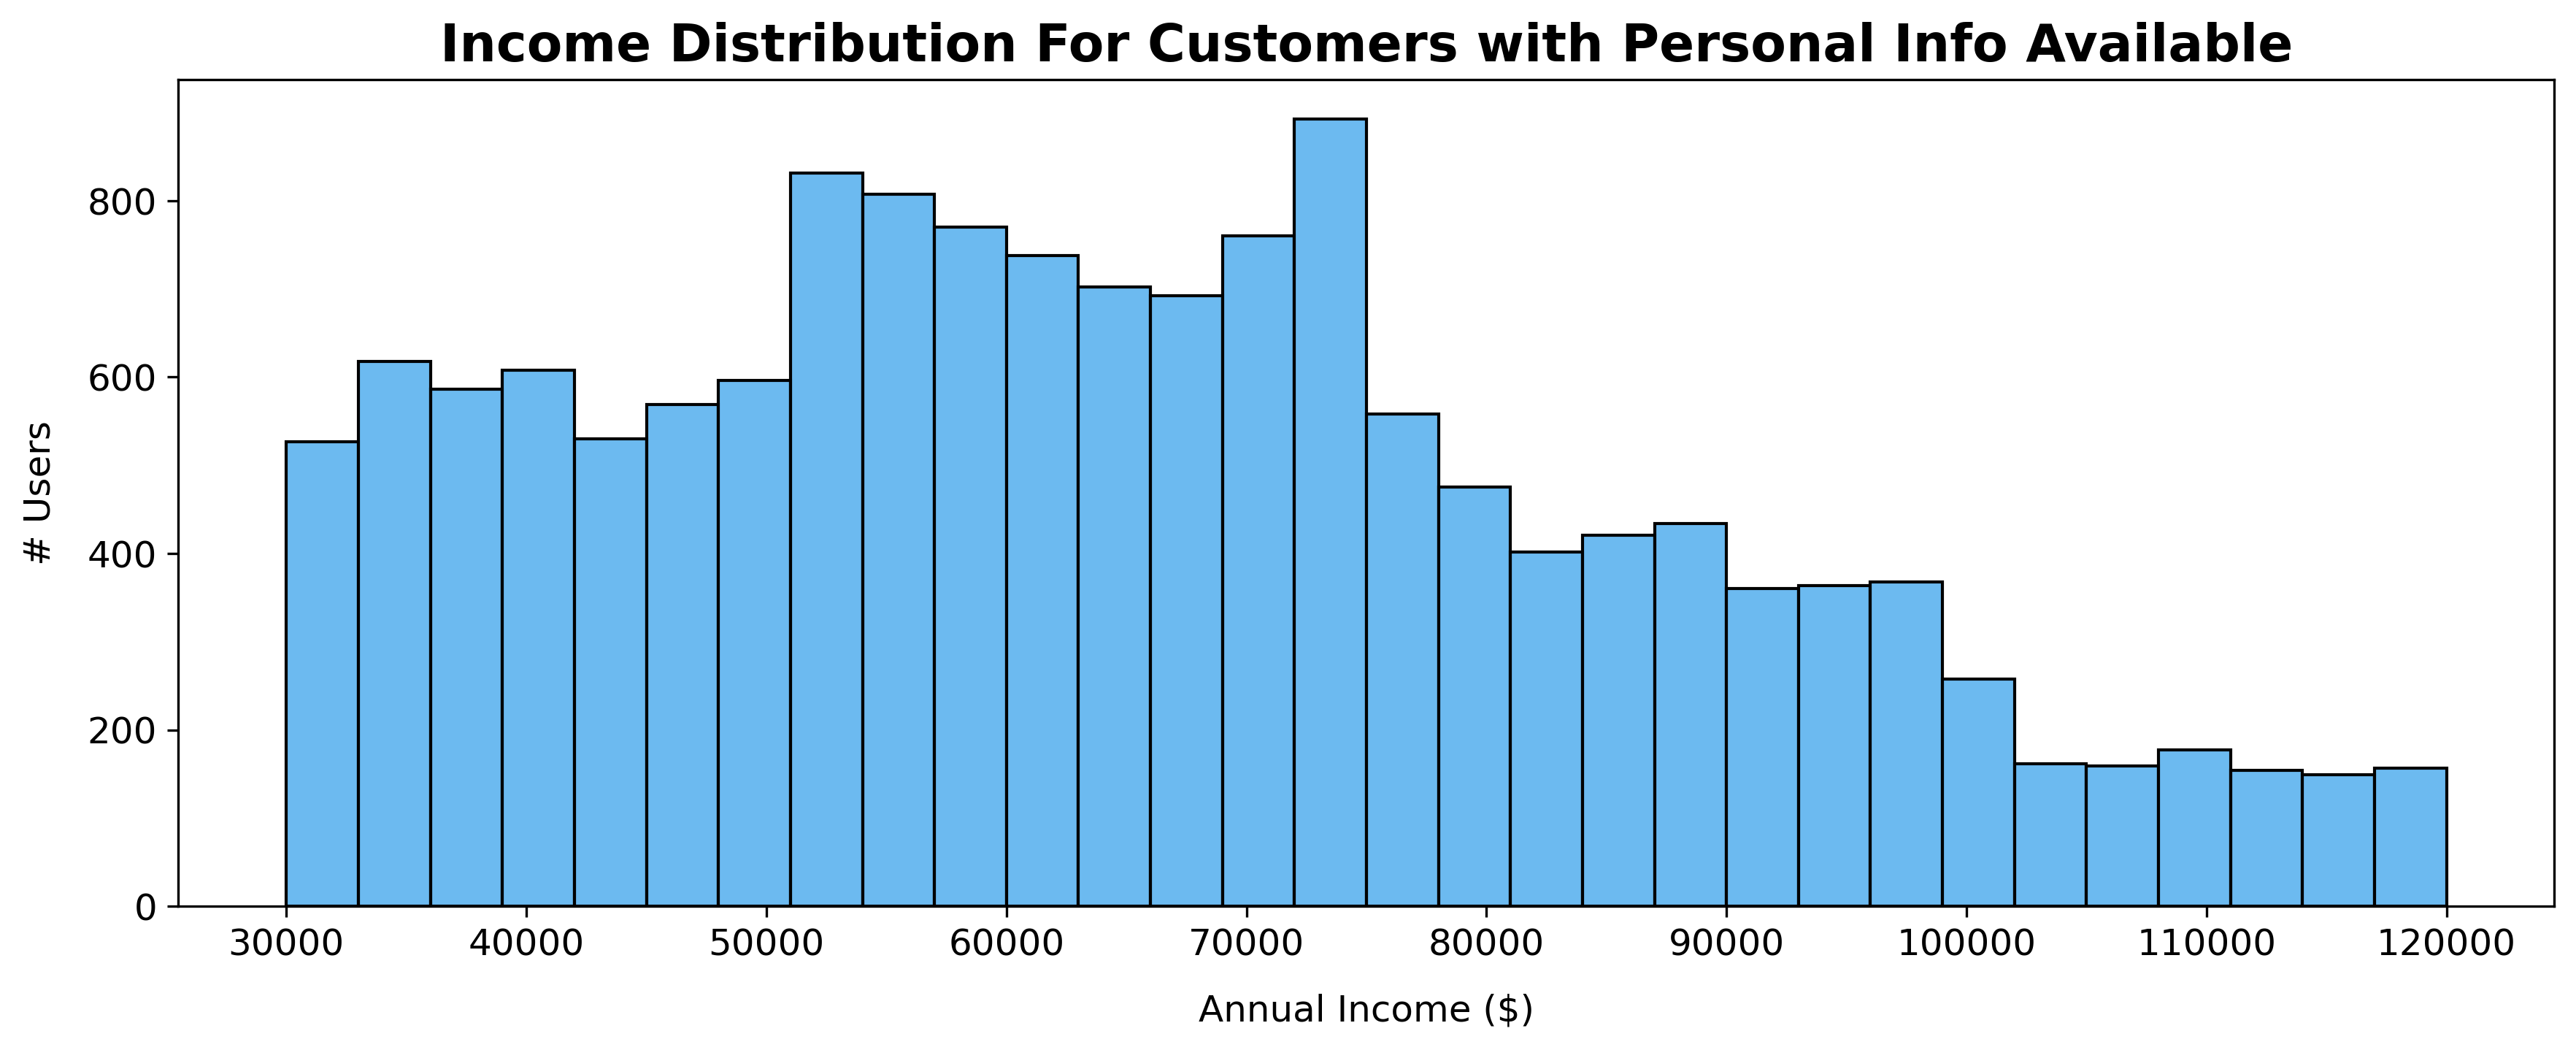

In [40]:
income_dist = profile[profile.user_info_provided==0]['income']
plt.figure(figsize = [14,5],  dpi=300 )
sns.histplot(income_dist, bins = 30, color = base)

plt.xlabel('Annual Income ($)',fontsize=12,labelpad=10)
plt.ylabel('# Users',fontsize=12,labelpad=10);
plt.xticks(range(30000,130000,10000),fontsize=12);
plt.yticks(fontsize=12);
plt.title('Income Distribution For Customers with Personal Info Available', fontsize=17, weight = 'bold');
plt.savefig('./screenshots/5_Income_Distribution_With_Personal_Info_Availabe_.png', dpi=600, bbox_inches ='tight')
plt.show()

After filtering out the customers who have not provided any personal info, its observed that many users have an annual income in the range between 30000 USD and 50000 USD and majority of the customers having income in the range between 50000 USD to 75000 USD. The income distribution gets lesser when salary range increases. Meaning there are less users who have high salary range.

**Now Let's start exploring the transcript dataset.**

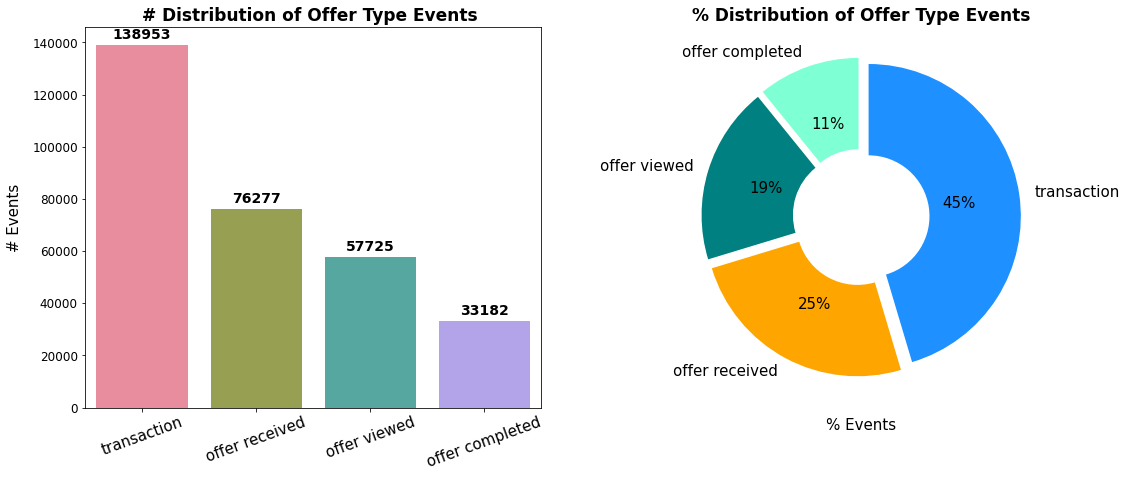

In [41]:
x =  transcript[['offer received','offer viewed','offer completed','transaction']].sum().sort_values(ascending = False).index
y = transcript[['offer received','offer viewed','offer completed','transaction']].sum().sort_values(ascending = False)

plt.figure(figsize = [18,7])
plt.tight_layout(pad =5)

# Bar chart
plt.subplot(1,2,1)
sns.barplot(x=x, y=y, order =y.sort_values(ascending=False).index, palette="husl", alpha=0.9)
plt.xticks(ticks=[0,1,2,3],labels=x.values,rotation = 20, fontsize=15);
plt.ylabel('# Events',fontsize=15,labelpad=10,rotation = 90)
plt.yticks(fontsize=12);
plt.title('# Distribution of Offer Type Events ', weight = 'bold', fontsize = 17)
for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+6500, count, ha = 'center', va ='top', fontsize = 14, rotation = 0, color = 'black', weight='bold')

    
# Donut chart
plt.subplot(1,2,2)
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
colors = ['dodgerblue', 'orange', 'teal', 'aquamarine']
#explsion
explode = (0.05,0.05,0.05,0.05)
 
plt.pie(y, startangle = 90,  counterclock = False, labels=x.values,colors = colors,explode = explode, \
        autopct='%1.0f%%', wedgeprops = {'width' : 0.6}, textprops={'fontsize': 15});
#plt.legend(loc="upper right");
plt.title('% Distribution of Offer Type Events', weight = 'bold', fontsize = 17)
plt.ylabel('')
plt.xlabel('% Events',fontsize=15,labelpad=10)
plt.savefig('./screenshots/6_Distribution_of_Offer_Type_Events.png', dpi=600, bbox_inches ='tight')
plt.show()

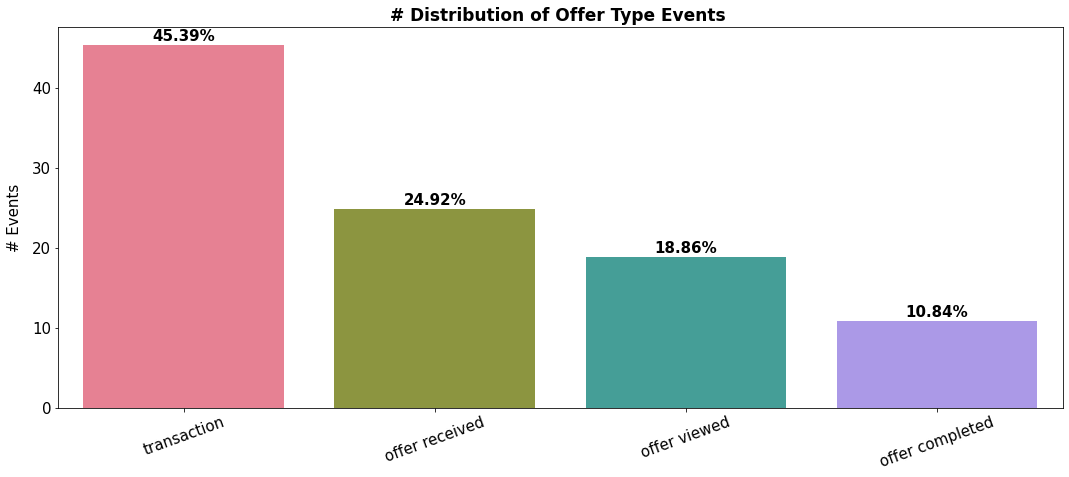

In [42]:
#event_dist = transcript[['offer received','offer viewed','offer completed','transaction']].sum()
x =  transcript[['offer received','offer viewed','offer completed','transaction']].sum().sort_values(ascending = False).index
y = round(transcript[['offer received','offer viewed','offer completed','transaction']].sum()/transcript[['offer received','offer viewed','offer completed','transaction']].shape[0]*100,2).sort_values(ascending = False)

plt.figure(figsize = [18,7])

# Bar chart
sns.barplot(x=x, y=y, order =y.sort_values(ascending=False).index, palette="husl", alpha=1)
plt.xticks(ticks=[0,1,2,3],labels=x.values,rotation = 20, fontsize=15);
plt.ylabel('# Events',fontsize=15,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);
plt.title('# Distribution of Offer Type Events ', weight = 'bold', fontsize = 17)


for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+2, str(count)+"%", ha = 'center', va ='top', fontsize = 15, rotation = 0, color = 'black', weight='bold')

plt.savefig('./screenshots/6_1_Distribution_of_Offer_Type_Events.png', dpi=600, bbox_inches ='tight')
plt.show()

It's clearly visible that the distribution of the events in the transcript dataset has two kind of events. 1 is offer type and the other is transactions.

* **Offer** - which has again the categories as **Received Offers, Viewed Offers, Completed Offers**

* **Transaction** - represents the records for which a transaction is made by customer

There are almost 55% of records in the transcript dataset contains events with all offer related data i.e. 24.92% is offer received, 18.86% is offer viewed, 10.84% is offer completed. And 45% records are of transactions type data. 

Hence it can be deduced that not all customers who received the offer viewed it and not all customers who viewed the offer completed it. 

**Here is the percentage of offers viewd from all the offers sent to customers.**

In [43]:
round((transcript[transcript['offer viewed']==1].shape[0]/transcript[transcript['offer received']==1].shape[0])*100, 2)

75.68

This raises the following question again.

**1. which transactions were completed because of the sent offers?**

**2. what are the characteristics of users who completed the offers?**

To answer those questions lets continue our data exploration and analysis. Let's begin with the column rename and merging of the data sets.


In [44]:
portfolio.rename(columns={"id":"offer_id","reward":"offer_reward"},inplace=True)
transcript.rename(columns={"person":"user_id","offer viewed":"offer_viewed",\
                           "offer received":"offer_received",\
                          "offer completed":"offer_completed"},inplace=True)
profile.rename(columns={"id":"user_id"},inplace=True)

In [45]:
pd.set_option('display.max_columns', 50)
df = pd.merge(pd.merge(transcript, portfolio, on='offer_id',how='left'), profile, on='user_id')
df.head()

,user_id,time,offer_completed,offer_received,offer_viewed,transaction,offer_id,reward_given,amount,offer_reward,difficulty,duration,offer_type,is_bogo,is_discount,is_informational,email,mobile,social,web,gender,age,became_member_on,income,gender_F,gender_M,gender_O,user_info_provided
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00,5.0,5.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0.00,5.0,5.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0,1,0,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,NaN,0,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0,1,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,0.00,5.0,5.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,NaN,0,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,75,2017-05-09,100000.0,1,0,0,0


Since reward_given and the offer_reward columns are identicle for all records having offer completed (offer_completed==1). So let's drop the reward_given column.

In [46]:
(df[df.offer_completed==1]['reward_given']-df[df.offer_completed==1]['offer_reward']).sum()

0.0

In [47]:
df.drop(['reward_given'],axis =1,inplace=True)

**Now let's look at the distribution of the offers sent to Customers**

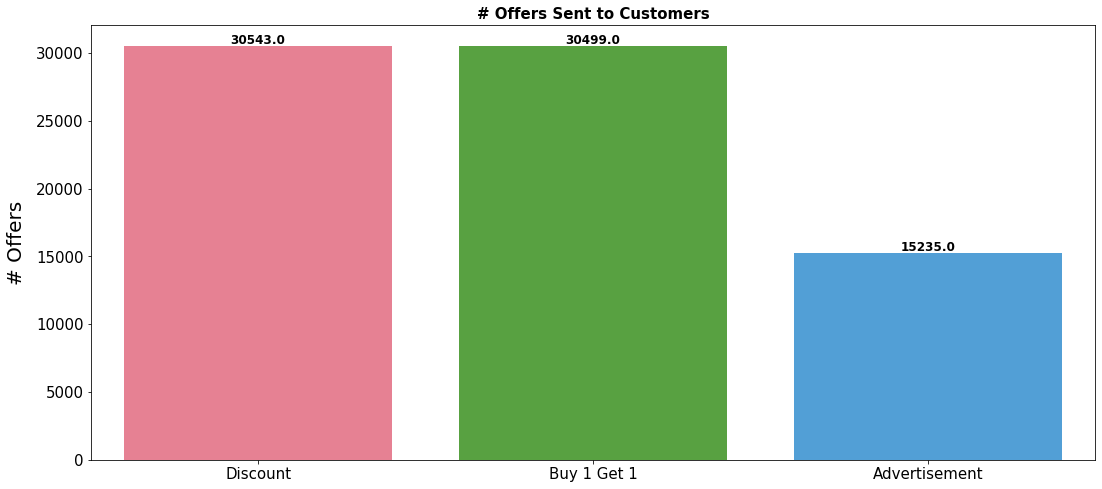

In [48]:
x = df[df['offer_received']==1][['is_bogo','is_discount','is_informational']].sum().sort_values(ascending=False).index
y = df[df['offer_received']==1][['is_bogo','is_discount','is_informational']].sum().sort_values(ascending=False)

plt.figure(figsize = [18,8])
sns.barplot(x=x, y=y, order =y.sort_values(ascending=False).index, palette="husl", alpha=1)

plt.xticks(ticks=[0,1,2], labels=['Discount', 'Buy 1 Get 1','Advertisement'],rotation = 0,fontsize=15);
plt.ylabel('# Offers',fontsize=20,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);
plt.title('# Offers Sent to Customers', weight = 'bold', fontsize = 15)

for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+900, count, ha = 'center', va ='top', fontsize = 12, rotation = 0, color = 'black', weight='bold')

plt.savefig('./screenshots/7_No_Of_Offers_Sent_To_Customers.png', dpi=600, bbox_inches ='tight')
plt.show()

From the visualization, we can conclude almost same number of BOGO (Buy 1 Get 1) and Discount offers are sent to users which is almost double the number of Advertisement offers sent.

Now let's select records where transactions are occurred after receiving an offer and while that offer is valid. 

To achieve this let's divide the dataframe into 3 groups based on offer received, offer viewed and offer completed. Then merge the data frames and add an offer_expiry column to display deadline for each offer ids.

In [49]:
# create a dataframe with all offers received
df_offer_received = df[df['offer_received'] == 1][['offer_id','user_id','time','duration']].rename(columns={"time":"time_received"})

# create a dataframe with all offers viewed
df_offer_viewed = df[df['offer_viewed'] == 1][['offer_id','user_id','time']]

# create a dataframe with all offers completed
df_offer_completed = df[df['offer_completed'] == 1][['offer_id','user_id','time']]

Now we merge those dataframes on **user_id** and **offer_id** columns, to be able to compare the time between transactions.

In [50]:
# merge offers completed and offers viewd dataframes
merged_df = pd.merge(df_offer_completed,df_offer_viewed, on=['offer_id','user_id'], suffixes=('_completed','_viewed'))

# then merge with offers received dataframe
merged_df = pd.merge(merged_df,df_offer_received, on=['offer_id','user_id'])
merged_df.head()

,offer_id,user_id,time_completed,time_viewed,time_received,duration
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,132,6,0,7.0
1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,510,408,408,7.0
2,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,510,582,504,5.0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,522,420,408,7.0
4,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,522,522,504,10.0


In [51]:
#Add offer deadline column to findout users who completed the offer after viewing it and before it expires.
merged_df['offer_deadline'] = merged_df.apply(lambda x: x['time_received']+int(x['duration'])*24,axis =1)
merged_df.head()

,offer_id,user_id,time_completed,time_viewed,time_received,duration,offer_deadline
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,132,6,0,7.0,168
1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,510,408,408,7.0,576
2,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,510,582,504,5.0,624
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,522,420,408,7.0,576
4,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,522,522,504,10.0,744


Let's ensure no user completed an offer in the same hour twice. This will allow to remove duplicate values in the merged dataframe.

In [52]:
df[(df['offer_completed']==1)].groupby(['offer_id','user_id','time']).size().max()

1

Let's ensure no user received an offer in the same hour twice. This will allow to remove duplicate values in the merged dataframe.

In [53]:
df[(df['offer_received']==1)].groupby(['offer_id','user_id','time']).size().max()

1

In [54]:
merged_df.shape

(59948, 7)

In [55]:
merged_df.drop_duplicates(subset=['offer_id','user_id','time_received']).shape

(30785, 7)

In [56]:
merged_df.drop_duplicates(subset=['offer_id','user_id','time_completed']).shape

(28382, 7)

In [57]:
# Remove duplicate entries with offer_id, user_id, time_completed and time_received
merged_df.drop_duplicates(subset=['offer_id','user_id','time_completed'], inplace = True)
merged_df.drop_duplicates(subset=['offer_id','user_id','time_received'], inplace = True)
merged_df.head()

,offer_id,user_id,time_completed,time_viewed,time_received,duration,offer_deadline
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,132,6,0,7.0,168
1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,510,408,408,7.0,576
2,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,510,582,504,5.0,624
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,522,420,408,7.0,576
4,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,522,522,504,10.0,744


In [58]:
merged_df.shape

(24460, 7)

Now that we removed the duplicate entries, let's select **users who completed the offer after viewing it and completed before it expires.**

In [59]:
merged_df = merged_df[(merged_df['time_viewed'] >= merged_df['time_received']) & (merged_df['time_completed'] <= merged_df['offer_deadline'])]
merged_df.head()

,offer_id,user_id,time_completed,time_viewed,time_received,duration,offer_deadline
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,132,6,0,7.0,168
1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,510,408,408,7.0,576
2,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,510,582,504,5.0,624
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,522,420,408,7.0,576
4,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,522,522,504,10.0,744


Lets compare this result with the original number of people who completed an offer through a visualization. This would clarify the 

**number of people who completed an offer after viewing it versus those who completed without viewing it.** 

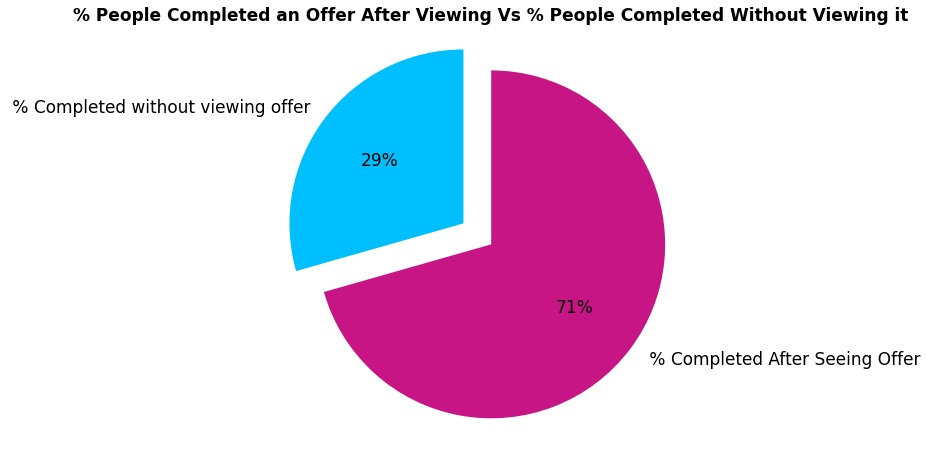

In [60]:
# Create a new column in the merged_df to identify the users who completed the offer after viewing it and before it expires.
#Same column will be created in the original df to identify the users who completed the offer but without seeing it.
merged_df['offer_success'] =1

# Merge dataframes on index
temp1 = df[df['offer_completed']==1].set_index(['offer_id','user_id','time'])
temp2 = merged_df.rename(columns={"time_completed":"time"}).set_index(['offer_id','user_id','time'])['offer_success']
comp_offer_stat_df = pd.merge(temp1,temp2,left_index=True,right_index=True,how="left")

# replace NaN values in offer_success column with 0
comp_offer_stat_df['offer_success'] = comp_offer_stat_df['offer_success'].fillna(0)

# Pie chart
plt.figure(figsize = [8,8])
explode = (0, 0.2)
colors = ['mediumvioletred', 'deepskyblue']

plt.pie(comp_offer_stat_df['offer_success'].value_counts(),startangle = 90,counterclock=False,autopct='%1.0f%%', explode= explode, colors = colors,\
                labels=[' % Completed After Seeing Offer',' % Completed without viewing offer'],\
                textprops={'fontsize': 17} )
plt.ylabel('')
plt.title('% People Completed an Offer After Viewing Vs % People Completed Without Viewing it', weight = 'bold', fontsize = 17)
plt.savefig('./screenshots/8_Offer_Completed_After_and_Before_Viewing.png', dpi=600, bbox_inches ='tight')
plt.show()

In [61]:
round(comp_offer_stat_df['offer_success'].value_counts()/comp_offer_stat_df.shape[0]*100, 0)

1.0    71.0
0.0    29.0
Name: offer_success, dtype: float64

Based on the pie chart its evident that 71% of completed offers were made after users viewed them. 

**Let's look at the effect of advertisement on the transactions that users have made.**

In [62]:
# create a dataframe with promotional offers received
promo_recvd_offers = df[(df['offer_received'] == 1) & (df['is_informational'] == 1)][['offer_id','user_id','time','duration']]\
.rename(columns={"time":"time_received"})

# create a dataframe with promotional offers viewed
promo_viewed_offers = df[(df['offer_viewed'] == 1) & (df['is_informational'] == 1)][['offer_id','user_id','time']]

# create a dataframe with all the offers where a transaction is made by user
trans_df = df[(df['transaction'] == 1)][['user_id', 'time','amount']]

# merge transaction and promotional offers viewed dataframes
promo_merged_df = pd.merge(trans_df, promo_viewed_offers, on=['user_id'],suffixes=('_transaction','_viewed'))

# again merge the dataframe with promotional received dataframe
promo_merged_df = pd.merge(promo_merged_df,promo_recvd_offers, on=['offer_id','user_id'])

# Calculate deadline
promo_merged_df['promo_deadline'] = promo_merged_df.apply(lambda x: x['time_received']+int(x['duration'])*24,axis =1)
promo_merged_df.head()

,user_id,time_transaction,amount,offer_id,time_viewed,time_received,duration,promo_deadline
0,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,5a8bc65990b245e5a138643cd4eb9837,216,168,3.0,240
1,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,5a8bc65990b245e5a138643cd4eb9837,216,168,3.0,240
2,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,5a8bc65990b245e5a138643cd4eb9837,216,168,3.0,240
3,78afa995795e4d85b5d9ceeca43f5fef,240,29.72,5a8bc65990b245e5a138643cd4eb9837,216,168,3.0,240
4,78afa995795e4d85b5d9ceeca43f5fef,378,23.93,5a8bc65990b245e5a138643cd4eb9837,216,168,3.0,240


In [63]:
#Ensure no user completed a transaction in the same hour twice. 
df[(df['transaction']==1)].groupby(['user_id','time']).size().max()

1

In [64]:
# Remove duplicate rows
promo_merged_df.drop_duplicates(subset=['user_id','time_transaction'], inplace= True)

# Filter to get transactions that happened because of an advertisement
promo_merged_df = promo_merged_df[(promo_merged_df['time_transaction'] >= promo_merged_df['time_received']) &\
                 (promo_merged_df['time_transaction'] <= promo_merged_df['promo_deadline'])]

# mark users influenced by advertisement offer
promo_merged_df['offer_success'] =1

# Merge dataframes on index
temp_promo1=df[df['transaction']==1].set_index(['user_id','time'])
temp_promo2 = promo_merged_df.rename(columns={"time_transaction":"time"}).set_index(['user_id','time'])['offer_success']
promo_df_final = pd.merge(temp_promo1,temp_promo2,left_index=True,right_index=True,how="left")

# replace NaN values in offer_success column with 0
promo_df_final['offer_success'] = promo_df_final['offer_success'].fillna(0)

Finally, let's combine both dataframes, to see overall effect of an offer, whether it's **BOGO, Discount** or **Advertisement** on the behaviour of the user.

In [65]:
final_df = pd.concat([comp_offer_stat_df.reset_index(),promo_df_final.reset_index()])
final_df.head()

,offer_id,user_id,time,offer_completed,offer_received,offer_viewed,transaction,amount,offer_reward,difficulty,duration,offer_type,is_bogo,is_discount,is_informational,email,mobile,social,web,gender,age,became_member_on,income,gender_F,gender_M,gender_O,user_info_provided,offer_success
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.0,5.0,5.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0,F,75,2017-05-09,100000.0,1,0,0,0,1.0
1,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,0,0.0,10.0,10.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,1.0,0.0,F,75,2017-05-09,100000.0,1,0,0,0,1.0
2,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,510,1,0,0,0,0.0,5.0,5.0,5.0,bogo,1.0,0.0,0.0,1.0,1.0,1.0,1.0,F,75,2017-05-09,100000.0,1,0,0,0,1.0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,522,1,0,0,0,0.0,5.0,5.0,7.0,bogo,1.0,0.0,0.0,1.0,1.0,0.0,1.0,M,68,2018-04-26,70000.0,0,1,0,0,1.0
4,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,522,1,0,0,0,0.0,2.0,10.0,10.0,discount,0.0,1.0,0.0,1.0,1.0,1.0,1.0,M,68,2018-04-26,70000.0,0,1,0,0,1.0


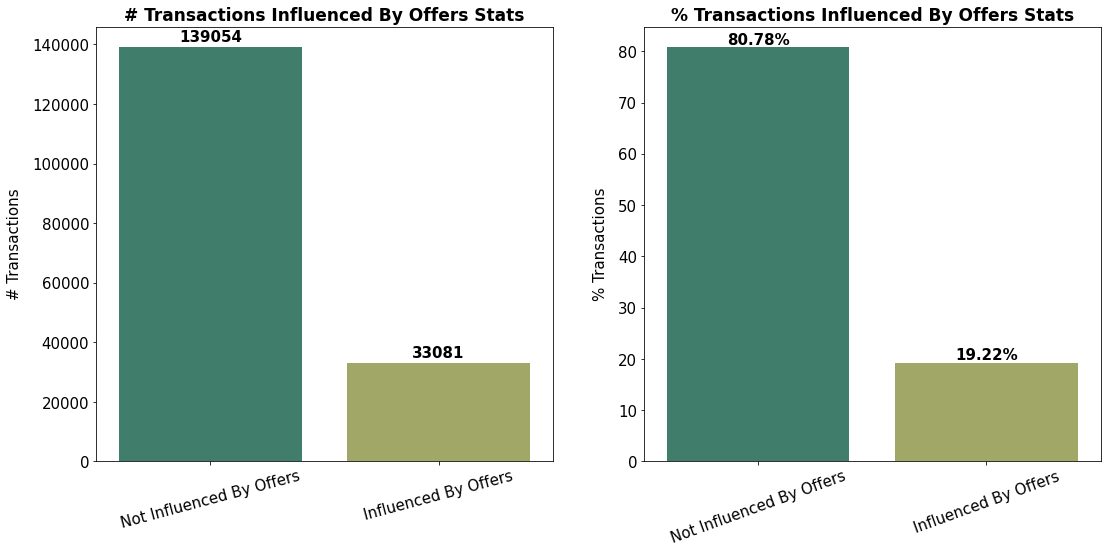

In [66]:
x = final_df['offer_success'].value_counts().index
y = final_df['offer_success'].value_counts()
# Plotting
plt.figure(figsize = [18,8])

# Bar chart
plt.subplot(1,2,1)
sns.barplot( x=x, y=y, palette = 'gist_earth' )

plt.xticks(ticks=[0,1],labels=['Not Influenced By Offers','Influenced By Offers'],rotation = 15, fontsize=15);
plt.ylabel('# Transactions',fontsize=15,labelpad=10,rotation = 90)
plt.yticks(fontsize=15);
plt.title('# Transactions Influenced By Offers Stats', weight = 'bold', fontsize = 17)

for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+6000, count, ha = 'center', va ='top', fontsize = 15, rotation = 0, color = 'black', weight='bold')


plt.subplot(1,2,2)
y = round(final_df['offer_success'].value_counts()/final_df['offer_success'].shape[0]*100,2)
sns.barplot( x=x, y=y,palette = 'gist_earth' )
plt.ylabel('')
plt.xticks(ticks=[0,1],labels=['Not Influenced By Offers','Influenced By Offers'],rotation = 20, fontsize=15);
plt.yticks(fontsize=15);
plt.ylabel('% Transactions',fontsize=15,labelpad=10,rotation = 90)
plt.title('% Transactions Influenced By Offers Stats', weight = 'bold', fontsize = 17)

for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+3, str(count)+"%", ha = 'center', va ='top', fontsize = 15, rotation = 0, color = 'black', weight='bold')


plt.savefig('./screenshots/9_Transactions_Influenced_By_Offers_Stats.png', dpi=600, bbox_inches ='tight')
plt.show()

So there are **33081** transactions i.e. **19.22%** of the total transactions that are influenced by the offers.

#### Now let's dive into the characteristics of users those who are influenced by offers. 

First let's see how the gender affects the amount spent in a transaction, in a way **which type of discount attracts which gender and plot Gender wise average amount spent.** for ths customers where personal info is available.

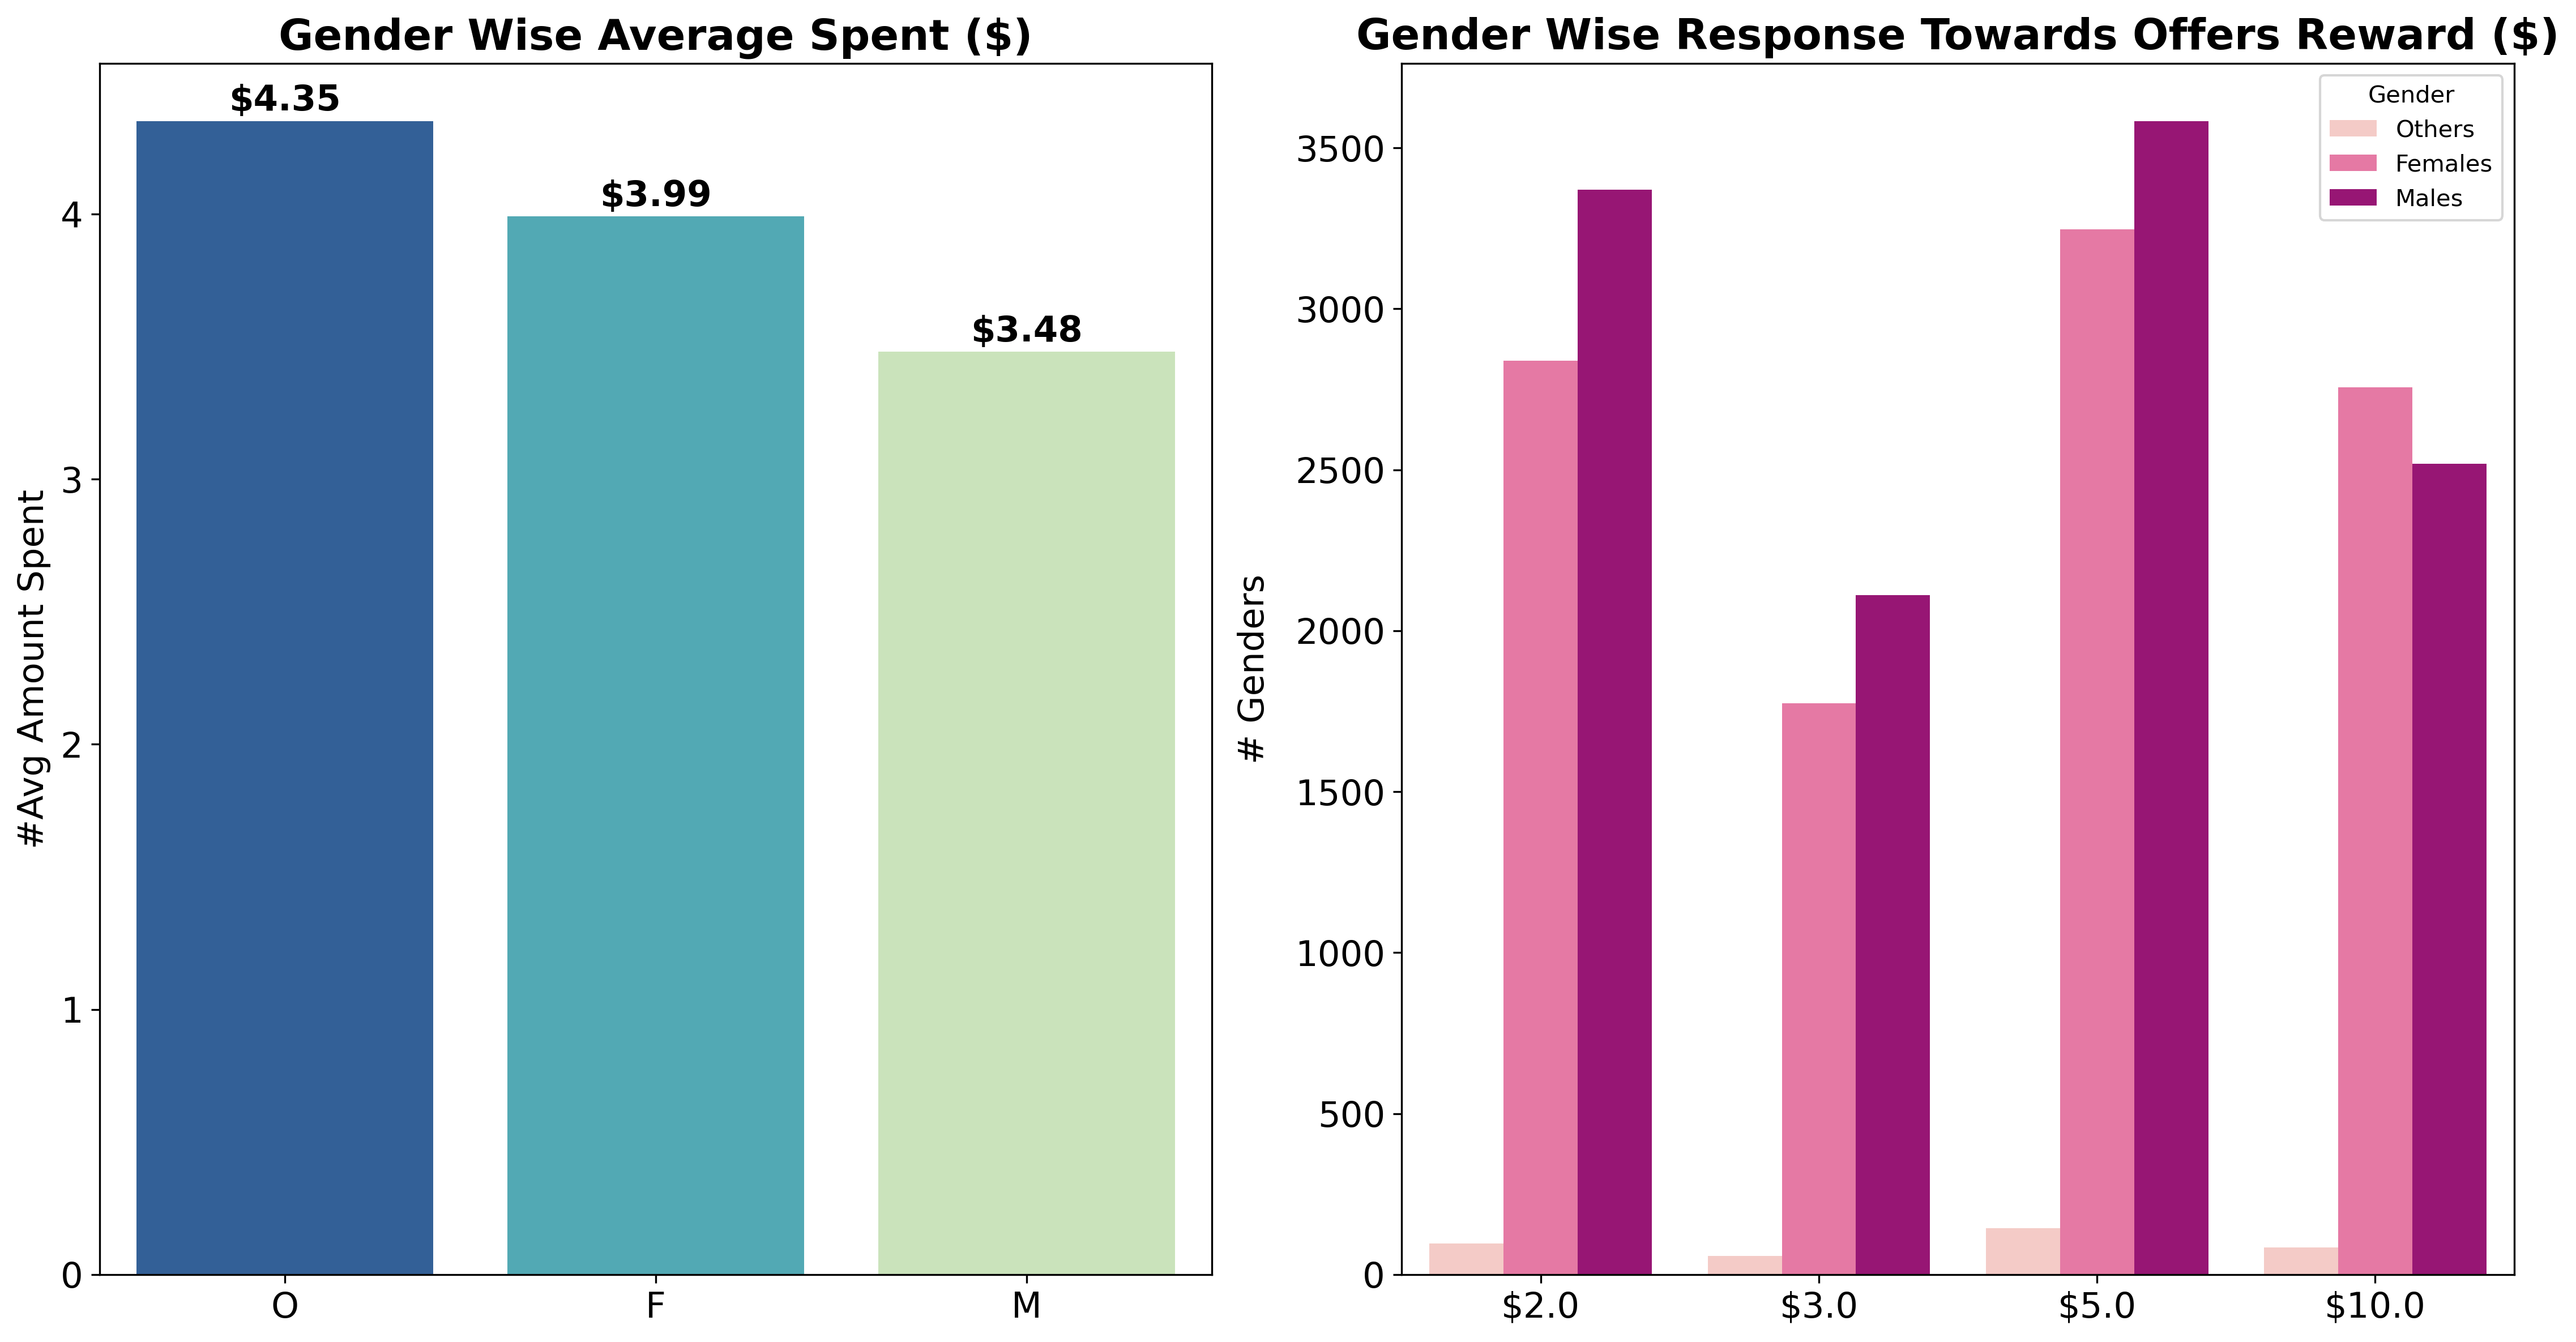

In [67]:
#Visualize Gender wise average Spent and which type of discount attracts which gender
plt.figure(figsize = [15,8], dpi = 300)
plt.subplots_adjust(wspace = 0.3)

plt.subplot(1,2,1)
gender_df = final_df[(final_df['user_info_provided']==0) &(final_df['offer_success']==1)].groupby(['gender']).mean()
x = gender_df.amount.sort_values(ascending =False).index
y = round(gender_df.amount.sort_values(ascending =False), 2)

sns.barplot(data = gender_df, x=x, y=y, palette = 'YlGnBu_r');
plt.xticks(ticks=[0,1,2],labels=x.values,fontsize=15)
plt.xlabel('');
plt.ylabel('#Avg Amount Spent', fontsize = 15);
plt.title('Gender Wise Average Spent ($)',fontsize=18, weight = 'bold');
plt.yticks(fontsize=15);

for i in range(y.shape[0]):
    count = y[i]
    plt.text(i, count+0.14, "$"+str(count), ha = 'center', va ='top', fontsize = 15, rotation = 0, color = 'black', weight='bold')

# Clustered Bar chart
plt.subplot(1,2,2)
data = final_df[(final_df['user_info_provided']==0) & (final_df['offer_success']==1)][['gender', 'offer_reward']]
sns.countplot(data=data,  x='offer_reward', hue = 'gender', hue_order = ['O', 'F', 'M'], palette = 'RdPu') #YlGnBu
plt.legend(title='Gender', loc='upper right', labels=['Others','Females', 'Males']);
plt.yticks(fontsize=15);
plt.xticks(ticks=[0,1,2,3],labels=['$2.0', '$3.0', '$5.0', '$10.0'],fontsize=15)
plt.xlabel('')
plt.title('Gender Wise Response Towards Offers Reward ($)',fontsize=18, weight = 'bold');
plt.ylabel('# Genders',fontsize=15,labelpad=10);

plt.tight_layout()
plt.savefig('./screenshots/10_Gender_Behaviour_Towards_Offer.png', dpi=600, bbox_inches ='tight')
plt.show()

From the barchart visualization, its observed that Females spend on  an average of 3.99 USD which is more than the average spend of males i.e 3.48 USD. And the other category seems to be spending the most with an average of USD 4.35. This is probably due to their low number compared to males and females. 

The visualization on the right display how the behaviour of genders attract towards offer rewards. Males seems to respond more towards 2.0 USD, 3.0 USD and 5.0 USD offer rewards than Females where as Females respond more towards 10.0 USD offer reward compared to males.

From the other categories, because of the less in numbers, a conclusion cannot be made however the visualization suggests they are respond slighly more towards 5.0 rewards.

#### A similar representation of the gender behaviour towards offer response is plotted using a Heatmap. 

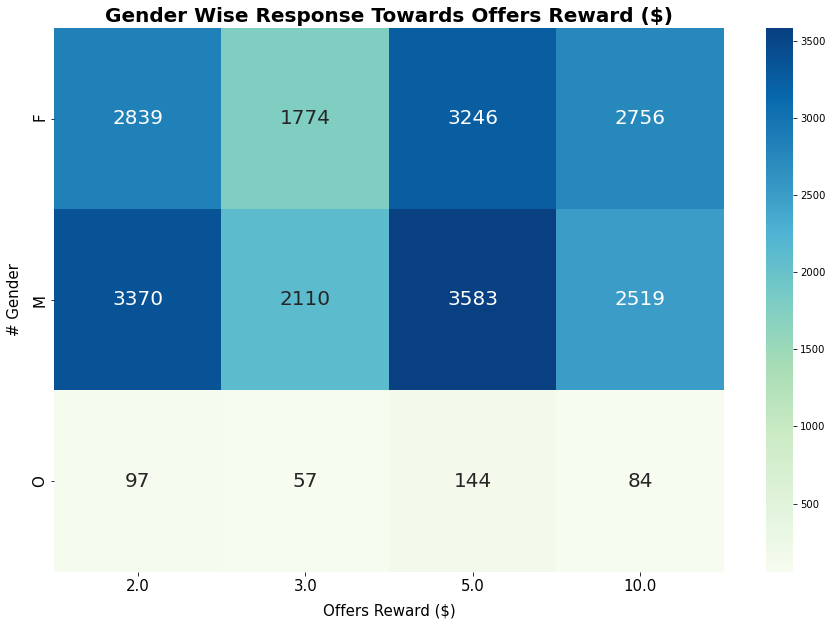

In [68]:
plt.figure(figsize = [15,10])
data = final_df[(final_df['user_info_provided']==0) & (final_df['offer_success']==1)][['gender', 'offer_reward']]
df_group = data.groupby(['gender', 'offer_reward']).size()
df_group = df_group.reset_index(name='count')
df_group = df_group.pivot(index = 'gender', columns = 'offer_reward', values = 'count')
sns.heatmap(df_group, annot = True, fmt = 'd', cmap="GnBu", cbar = True, annot_kws={"size": 20})
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Offers Reward ($)',fontsize=15,labelpad=10);
plt.ylabel('# Gender',fontsize=15,labelpad=10);
plt.title('Gender Wise Response Towards Offers Reward ($)', fontsize = 20, weight = 'bold' )


plt.savefig('./screenshots/10_1_Gender_Behaviour_Towards_Offer.png.png', dpi=600, bbox_inches ='tight')
plt.show()

In [69]:
#sns.swarmplot(data = final_df[(final_df['offer_success']==1)],x='user_info_provided',y='amount', palette = 'Set2');

Let's see **spread of data for amount spent by the users who completed the offer** after viewing it and before it expires **and for users who didn't complete the offer.**

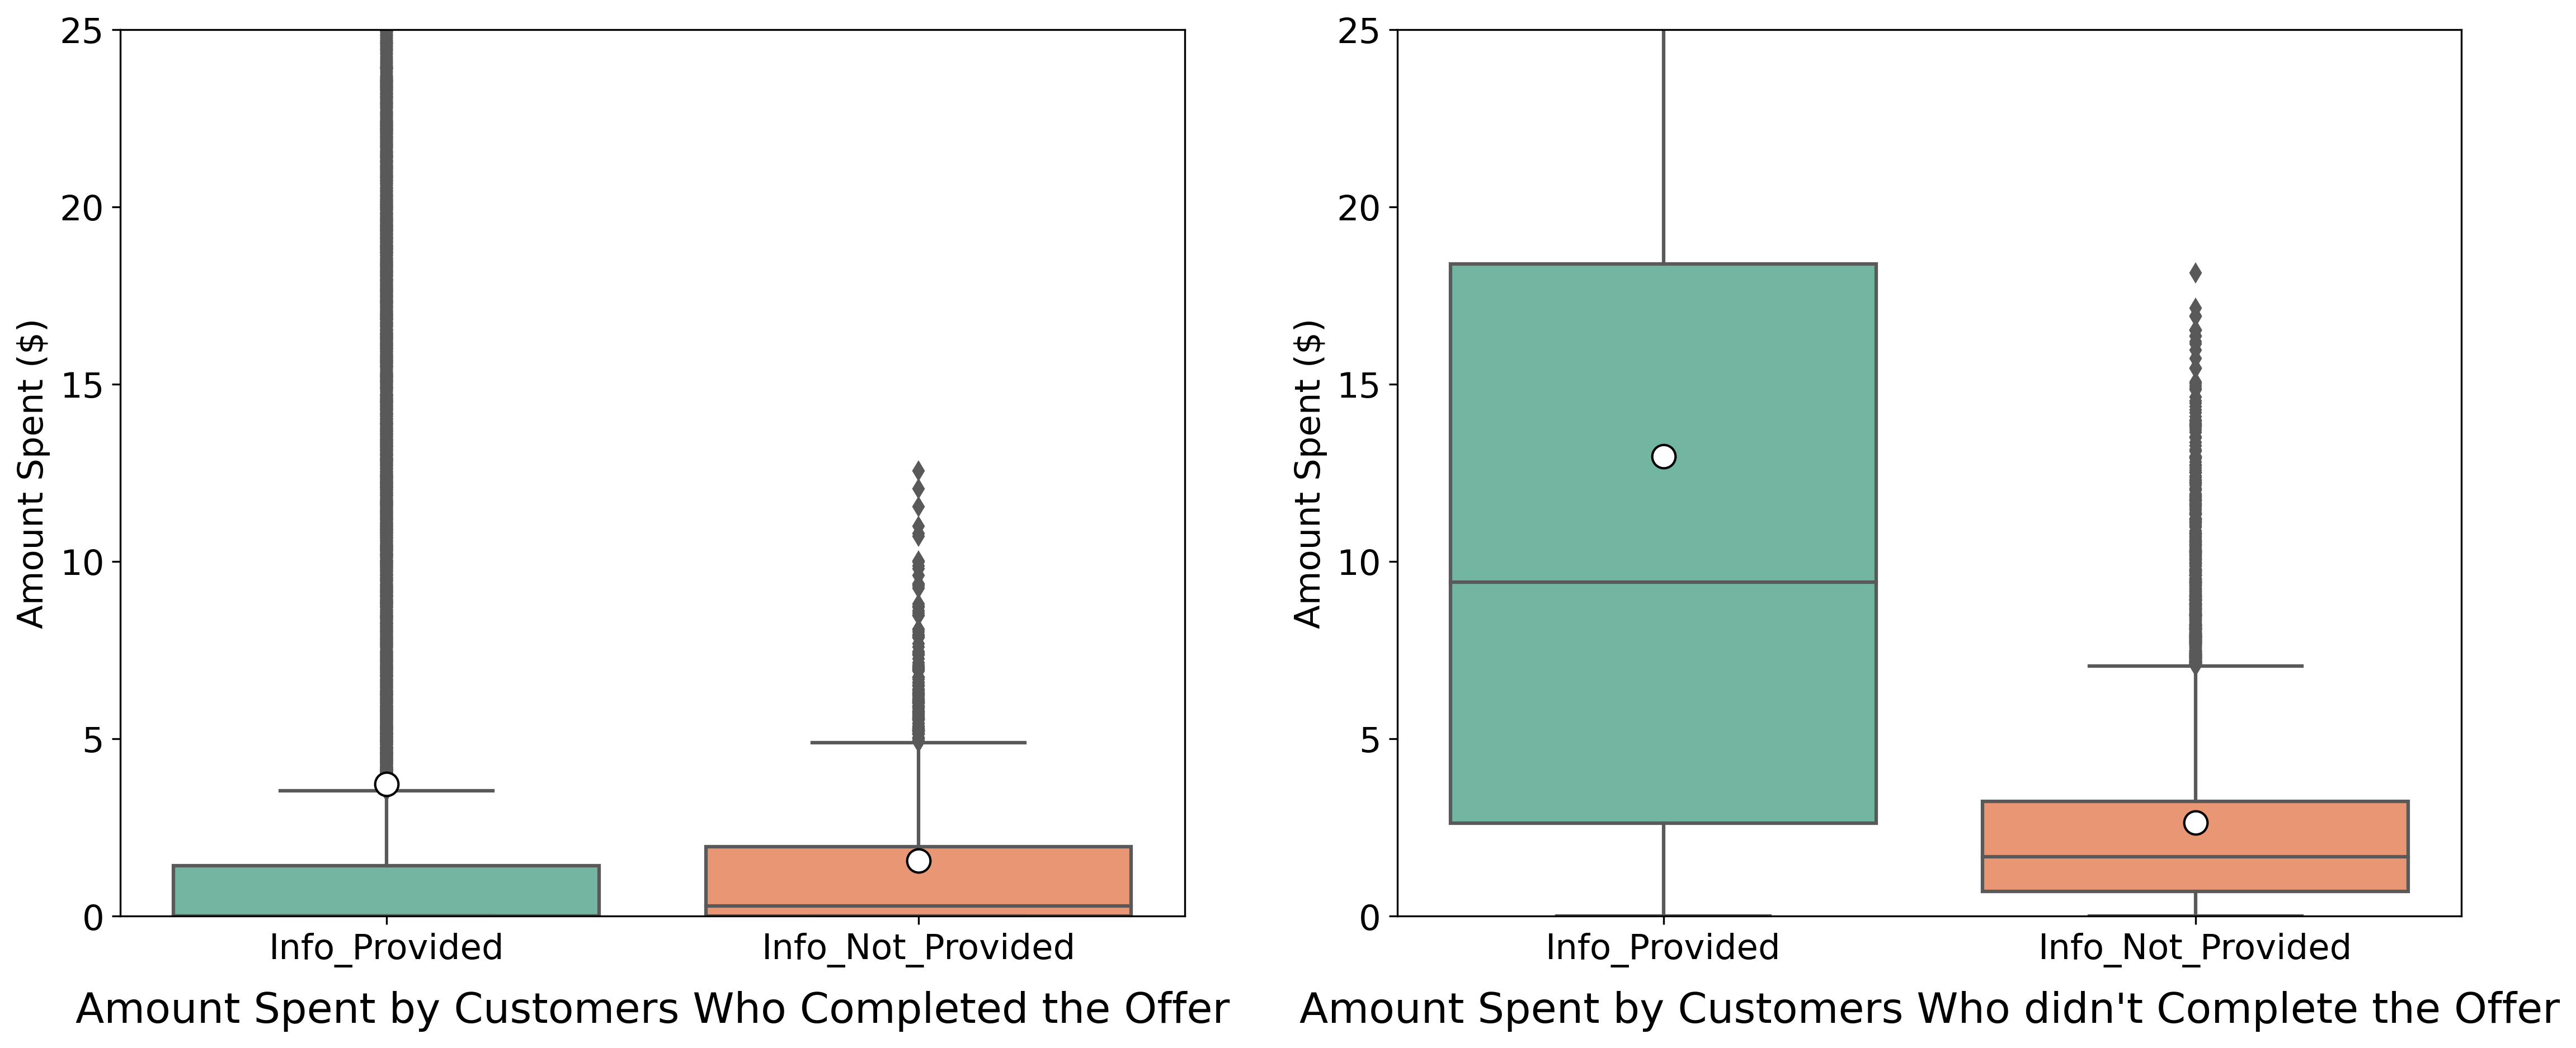

In [70]:
plt.figure(figsize = [18,7], dpi = 300)

plt.tight_layout(pad=3.0)

# Box plot to see the spread of data for amount spent by the users who completed the offer after viewing it and before it expires.
plt.subplot(1,2,1)
#plt.tight_layout(pad=3.0)

sns.boxplot(data = final_df[(final_df['offer_success']==1)],x='user_info_provided',y='amount', palette = 'Set2', showmeans=True,\
            meanprops={"marker":"o", "markerfacecolor":"white",  "markeredgecolor":"black", "markersize":"10"});
plt.xticks(ticks=[0,1,],labels= ['Info_Provided','Info_Not_Provided'],fontsize=15)
plt.ylim([0, 25])
plt.ylabel('Amount Spent ($)',fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Amount Spent by Customers Who Completed the Offer', fontsize = 18, labelpad =10)


# Box plot to see the spread of data for amount spent by the users who didn't complete the offer.
plt.subplot(1,2,2)

#plt.tight_layout(pad=3.0)

sns.boxplot(data = final_df[(final_df['offer_success']==0)],x='user_info_provided',y='amount', palette = 'Set2', showmeans=True,\
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"});
plt.xticks(ticks=[0,1,], labels = ['Info_Provided','Info_Not_Provided'],fontsize=15)
plt.ylim([0,25])
plt.ylabel('Amount Spent ($)',fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Amount Spent by Customers Who didn\'t Complete the Offer', fontsize = 18, labelpad =10)

plt.savefig('./screenshots/11_Spread_of_Amount_Spent_By_Users.png', dpi=600, bbox_inches ='tight')
plt.show()

From the left box plot, it's observed that customer who didn't provide any personal info tend to spend more per transaction for completed offers. 
However from the right box plot it's observed, customer who provided personal info tend to spend a lot more.

Since there are much outliers present for the amount spent by customers, hence the y axis is limitted to display the trend where the the spread is more.

Also find the coorelation between Age Groups and Amount spent by customers for the transactions with complted offers and without offers.

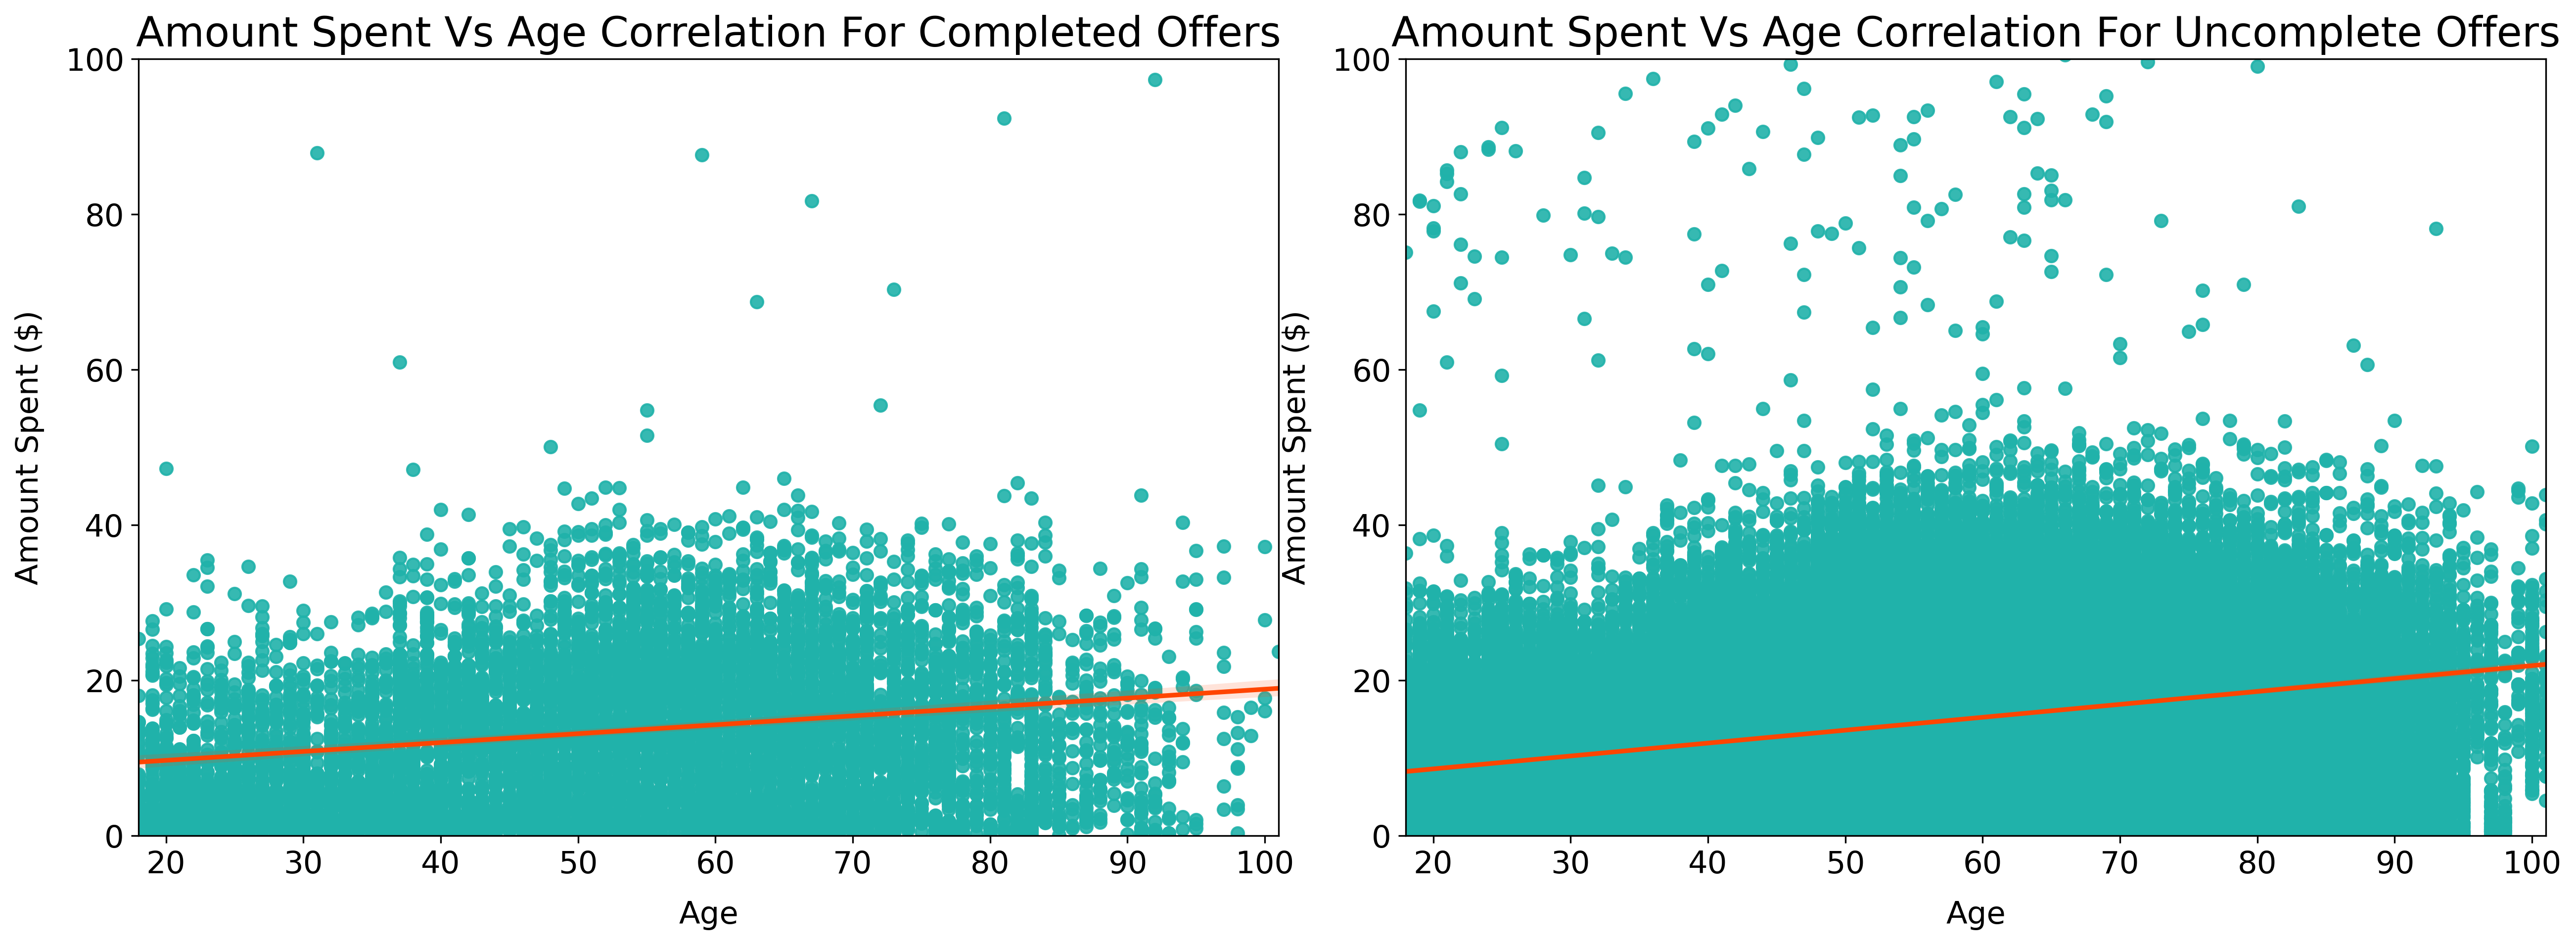

In [71]:
# Scatter plot with Regression line to visualize coorelation between Age Groups and Amount spent by customers for the transactions with complted offers
plt.figure(figsize = [18,7], dpi = 300)

plt.tight_layout(pad=3.0)
plt.subplot(1,2,1)

sns.regplot(data = final_df[(final_df['user_info_provided']==0) & (final_df['transaction']==1) & (final_df['offer_success']==1)]\
            ,x='age',y='amount',scatter_kws = { 'color': 'lightseagreen' ,'alpha':0.9},line_kws={'color': 'orangered'});
plt.ylim([0,100]);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.xlabel('Age',fontsize=15,labelpad=10);
plt.ylabel('Amount Spent ($)',fontsize=15,labelpad=10);
plt.title('Amount Spent Vs Age Correlation For Completed Offers', fontsize = 20)


# Scatter plot with Regression line to visualize coorelation between Age Groups and Amount spent by customers for the transactions without complted offers
plt.subplot(1,2,2)
plt.tight_layout(pad=3.0)

sns.regplot(data = final_df[(final_df['user_info_provided']==0) & (final_df['transaction']==1) & (final_df['offer_success']==0)]\
            ,x='age',y='amount',scatter_kws = { 'color': 'lightseagreen' ,'alpha':0.9},line_kws={'color': 'orangered'});

plt.ylim([0,100]);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Age',fontsize=15,labelpad=10);
plt.ylabel('Amount Spent ($)',fontsize=15,labelpad=10);
plt.title('Amount Spent Vs Age Correlation For Uncomplete Offers', fontsize = 20)

plt.savefig('./screenshots/12_Amount_Spent_Vs_Age_Correlation.png', dpi=600, bbox_inches ='tight')
plt.show()

From the above scatter plot with fitted regression line, its observed that there is almost positive coorelation between the Average amount spent and age groups for both completed and uncomplete offers with a dense of data showed between the age group of late 50s to late 60s. People with higher ages tend to spend more on the transaction amount in both cases.

Since there are much outliers present for the amount spent by customers, hence the y axis is limitted to display the trend where the the spread is more.

Now lets' see **how Customers responded to offers when different channesls used.**

First fiter data into two categories. First, channels used for completed offers and second Channels used for not completed offers

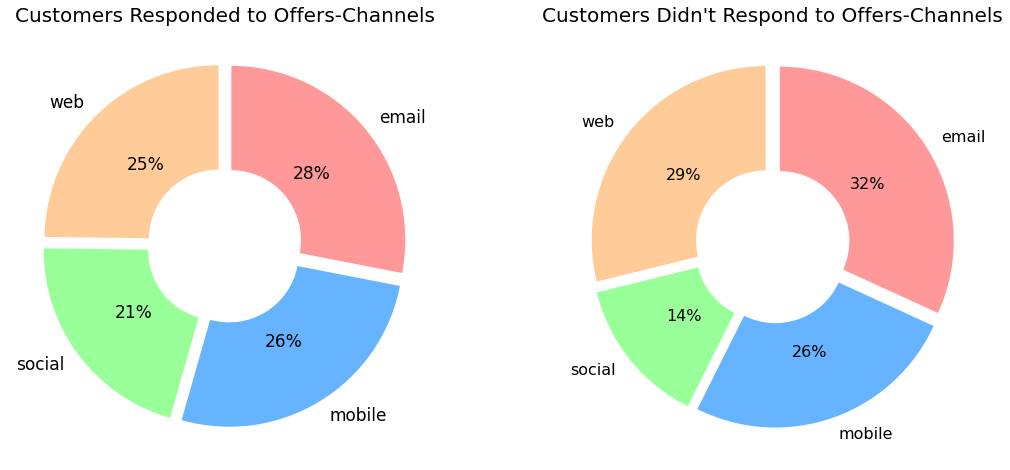

In [72]:
channel_offer_succ = final_df[(final_df['offer_success']==1)][['email','mobile','social','web']].sum()
channel_offer_fail = final_df[(final_df['offer_success']==0)][['email','mobile','social','web']].sum()

plt.figure(figsize = [18,8])

#Pie chart to visualize how customers respond to offers for different channels 
plt.subplot(1,2,1)

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#colors = ['dodgerblue', 'orange', 'teal', 'aquamarine']
#explsion
explode = (0.05,0.05,0.05,0.05)
plt.pie(channel_offer_succ,labels =channel_offer_succ.index, startangle = 90,counterclock=False,autopct='%1.0f%%',textprops={'fontsize': 17}, colors = colors,explode = explode, wedgeprops = {'width' : 0.6})
plt.ylabel('')
plt.title('Customers Responded to Offers-Channels',fontsize=20);

#Pie chart to visualize how customers didn't respond to offers for different channels
plt.subplot(1,2,2)
#colors = ['dodgerblue', 'orange', 'teal', 'aquamarine']
plt.pie(channel_offer_fail,labels =channel_offer_fail.index, startangle = 90,counterclock=False,autopct='%1.0f%%',textprops={'fontsize': 16}, colors = colors,explode = explode, wedgeprops = {'width' : 0.6})
plt.ylabel('')
plt.title('Customers Didn\'t Respond to Offers-Channels',fontsize=20);

plt.savefig('./screenshots/13_Customer_Response_Via_Channels.png', dpi=600, bbox_inches ='tight')
plt.show() 

We can see that user responded to the offers almost the same percentage for all channels being used to sent them the offers.

Let's find the coorelation between Customer Income and Amount Spent by customers for the transactions with complted offers and without offers.

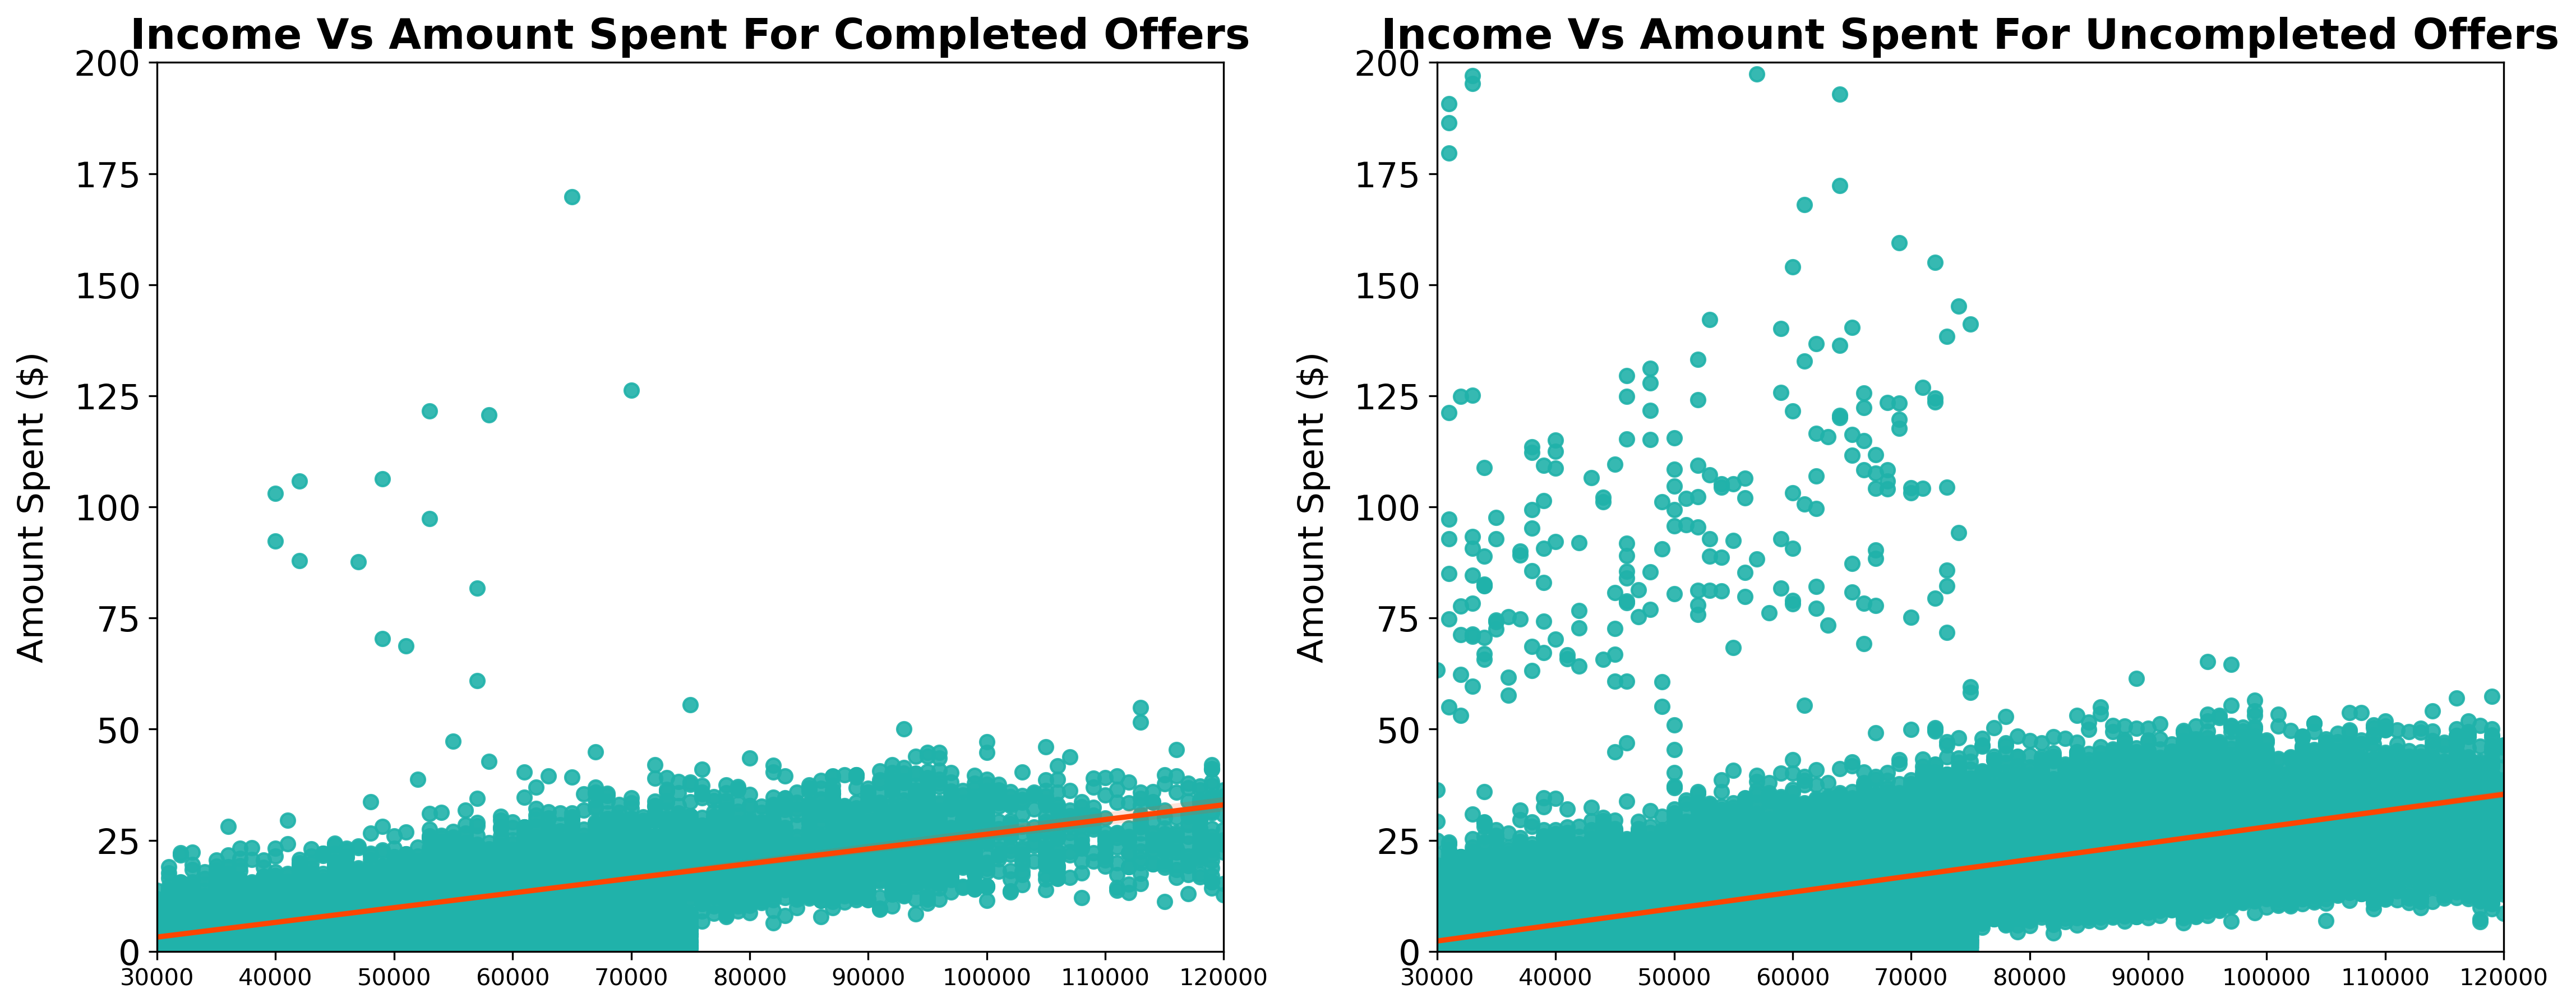

In [73]:
plt.figure(figsize = [18,7], dpi =300)

## Scatter plot with Regression line to visualize coorelation between Customer Income and Amount Spent by customers for the transactions with complted offers

base = sns.color_palette('Accent')[4]
# Clustered Bar chart
plt.subplot(1,2,1)
sns.regplot(data = final_df[(final_df['user_info_provided']==0) & (final_df['transaction']==1) & (final_df['offer_success']==1)], x_jitter=.3\
            ,x='income',y='amount', scatter_kws = { 'color': 'lightseagreen' ,'alpha':0.9},line_kws={'color': 'orangered'});
plt.ylim([0,200]);
plt.xticks(fontsize=10);
plt.yticks(fontsize=15);
plt.xlabel('')
plt.title('Income Vs Amount Spent For Completed Offers', fontsize = 18, weight = 'bold')
plt.ylabel('Amount Spent ($)',fontsize=15,labelpad=10);


## Scatter plot with Regression line to visualize coorelation between Customer Income and Amount Spent by customers for the transactions without complted offers
plt.subplot(1,2,2)
sns.regplot(data = final_df[(final_df['user_info_provided']==0) & (final_df['transaction']==1) & (final_df['offer_success']==0)], x_jitter=.3, y_jitter = 0.6\
            ,x='income',y='amount', scatter_kws = { 'color': 'lightseagreen' ,'alpha':0.9},line_kws={'color': 'orangered'});
plt.ylim([0,200]);
plt.xticks(fontsize=10);
plt.yticks(fontsize=15);
plt.xlabel('')
plt.title('Income Vs Amount Spent For Uncompleted Offers', fontsize = 18, weight = 'bold')
plt.ylabel('Amount Spent ($)',fontsize=15,labelpad=10);


plt.savefig('./screenshots/14_Income_Vs_Amount_Spent_Correlation.png', dpi=600, bbox_inches ='tight')
plt.show()

We can see that coorelation between Customer Income and Amount Spent by customers for both transactions with complted and not completed offers is positive. The amount spent per transaction is more when the user income is more, which is expected. 

Since there are much outliers present for the amount spent by customers, hence the y axis is limitted to display the trend where the dense of data is more.

**Next, let's see how the age plays a role in responding to offer rewards.**

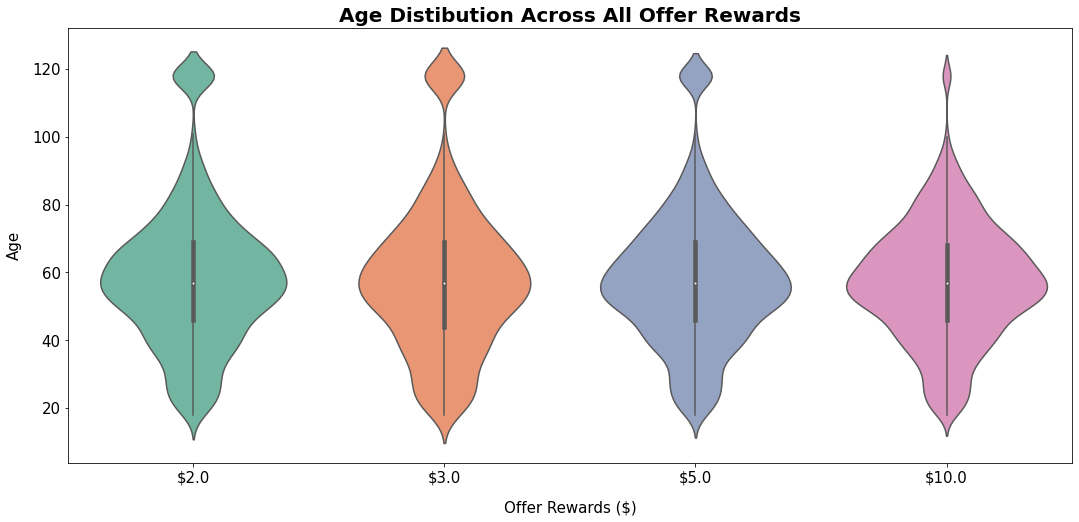

In [74]:
# Age Distribution across Offer Rewards
plt.figure(figsize = [18,8])
sns.violinplot(data = final_df[(final_df['offer_success']==1)],x='offer_reward',y='age', palette = 'Set2');
plt.xticks(ticks=[0,1,2,3],labels=['$2.0', '$3.0', '$5.0', '$10.0' ] ,fontsize=15)
plt.ylabel('Age',fontsize=15,labelpad=10);
plt.yticks(fontsize=15);
plt.xlabel('Offer Rewards ($)',fontsize=15,labelpad=15);
plt.title('Age Distibution Across All Offer Rewards', fontsize = 20, weight = 'bold')

plt.savefig('./screenshots/15_Age_Dist_Across_All_Offer_Rewards.png', dpi=600, bbox_inches ='tight')
plt.show()

Based on the above visualization, it's noticiable that age doesn't play a big role in responding to offers rewards, meaning all age group people respond to the offers almost in a similar fashion.

## Data Modeling

### Predict User Response

Now that we are done with the data exploration and analysis to answer the queries, lets build a model to predict the User Responses to see whether a user will respond to an offer or not.
To achieve let's assign our target variable i.e **offer_success** column to be predicted to **y**, and assign features i.e user demographics variables to **X**. 

Lets use RandomForestClassifier and LinearSVC modelling techniques to build our model and predict the user response.

In [75]:
# Drop unnecessary columns
model_df = final_df.drop(['offer_id','user_id','time','offer_received','offer_viewed',\
                          'is_informational','offer_type','gender','email','became_member_on'], axis=1)

In [76]:
# Fill missing values with zeros
model_df[['offer_reward','difficulty','duration','is_bogo','is_discount','mobile','social','web']] =\
model_df[['offer_reward','difficulty','duration','is_bogo','is_discount','mobile','social','web']].fillna(0)

In [77]:
# Fill missing values in income with mean value
model_df['income'] = model_df['income'].fillna(model_df['income'].mean())

In [78]:
# Assign Features to X and target variable to y
X = model_df.drop(['offer_success'],axis=1)
y = model_df['offer_success']
# split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scale features

In [79]:
# List of features to scale
features_to_scale  = ['offer_reward', 'duration', 'difficulty', 'age', 'income']

In [80]:
def features_scale(df, feat=features_to_scale):    
    
    """
    Scale list of features in a given dataframe
    
    INPUT:
    - df (dataframe): dataframe having features to scale
    - feat (list): list of features in dataframe to scale
            
    OUTPUT:
    - scaled_df (dataframe): dataframe containing scaled features
    """
        
    # Prepare dataframe with features to scale
    df_feat_scale = df[feat]
        
    # Apply feature scaling to df
    scaler = MinMaxScaler()
    df_feat_scale = pd.DataFrame(scaler.fit_transform(df_feat_scale), columns = df_feat_scale.columns,index=df_feat_scale.index)
        
    # Drop orignal features from df and add scaled features 
    df = df.drop(columns=feat, axis=1)
    df_scaled = pd.concat([df, df_feat_scale], axis=1)
        
    return df_scaled

In [81]:
# Scale selected features in training set i.e. X_train
X_train_scaled = features_scale(X_train, feat=features_to_scale)
X_train_scaled.head()

,offer_completed,transaction,amount,is_bogo,is_discount,mobile,social,web,gender_F,gender_M,gender_O,user_info_provided,offer_reward,duration,difficulty,age,income
52523,0,1,10.11,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.48,0.444444
76269,0,1,5.43,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0,0.0,0.42,0.022222
51021,0,1,7.57,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.47,0.033333
55273,0,1,16.84,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.0,0.42,0.222222
10195,1,0,0.00,0.0,1.0,1.0,0.0,1.0,0,1,0,0,0.2,0.7,0.5,0.23,0.544444


### Train Our Classifier

In [82]:
def fit_classifier(clf, param_grid, X=X_train_scaled.values, y=y_train.squeeze().values):

    """
    Fits a classifier to its training data using GridSearchCV and calculates f1_score
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train_scaled (DataFrame): training features
    - y_train (DataFrame): training label
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring f1 available as parameter
    start = time.time()
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='f1', cv=5, verbose=0)
    print("Training {} :".format(clf.__class__.__name__))
    grid.fit(X, y)
    end = time.time()
    time_taken = round(end-start,2)

    print(clf.__class__.__name__)
    print("Time taken : {} secs".format(time_taken))
    print("Best f1_score : {}".format(round(grid.best_score_,4)))
    print("*"*40)
    
    return grid.best_score_, grid.best_estimator_, time_taken

In [83]:
# Instantiate classification algorithm
Rf = RandomForestClassifier(random_state=42) # RandomForestClassifier

In [84]:
# Find f1 score and time taken for the classifier
cl_names = []
cl_scores = []
cl_best_ests = []
cl_time_taken = []
cl_dict = {}

for classifier in [ Rf]:
    best_score, best_est, time_taken = fit_classifier(classifier, {})
    cl_names.append(classifier.__class__.__name__)
    cl_scores.append(best_score)
    cl_best_ests.append(best_est)
    cl_time_taken.append(time_taken)

Training RandomForestClassifier :
RandomForestClassifier
Time taken : 156.52 secs
Best f1_score : 0.6145
****************************************


In [85]:
# Create the calsiification data frame from cl_dict
cl_dict['best_f1_score'] = cl_scores
cl_dict['time_taken(s)'] = cl_time_taken
cl_dict['best_est'] = cl_best_ests
cl_df = pd.DataFrame(cl_dict, index=cl_names)
cl_df

,best_f1_score,time_taken(s),best_est
RandomForestClassifier,0.614538,156.52,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


### Modeling using RandomForestClassifier

In [86]:
# display parametrs of RandomForestClassifier
cl_df.loc['RandomForestClassifier', 'best_est']

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [87]:
# Tuninig RandomForestClassifier classifier with the help of param grid in GridSearchCV
param_grid = {
               # Number of trees in random forest
              'n_estimators': [10, 50, 80, 100],
               # Maximum number of levels in tree
              'max_depth': [None],
               # Minimum number of samples required to split a node
              'min_samples_split': [2, 5, 10],
               # Minimum number of samples required at each leaf node
              'min_samples_leaf': [1, 2, 4]}

rfc = RandomForestClassifier(random_state=42)
rfc_best_score, rfc_best_est, _ = fit_classifier(rfc, param_grid)
rfc_best_est

Training RandomForestClassifier :
RandomForestClassifier
Time taken : 2372.35 secs
Best f1_score : 0.6868
****************************************


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

### Feature importance by RandomForestClassifier

In [88]:
# Prepare a dataframe with features and their importance by RandomForestClassifier
feature_imp_rfc = pd.DataFrame(rfc_best_est.feature_importances_,index=X_train_scaled.columns.tolist(),columns=['feat_imp']).reset_index()

feature_imp_rfc.rename(columns={'index': 'feature'}, inplace=True)
feature_imp_rfc['feat_imp_rate'] = np.round((feature_imp_rfc['feat_imp']/feature_imp_rfc['feat_imp'].sum())*100,2)
feature_imp_rfc = feature_imp_rfc.sort_values(by=['feat_imp_rate'], ascending=False).reset_index(drop=True)
feature_imp_rfc.drop(columns=['feat_imp'],inplace=True)
feature_imp_rfc

,feature,feat_imp_rate
0,amount,22.00
1,offer_completed,12.19
2,offer_reward,11.75
3,duration,10.56
4,income,9.49
5,age,9.39
6,transaction,8.29
7,difficulty,7.57
8,mobile,4.44
9,social,3.31


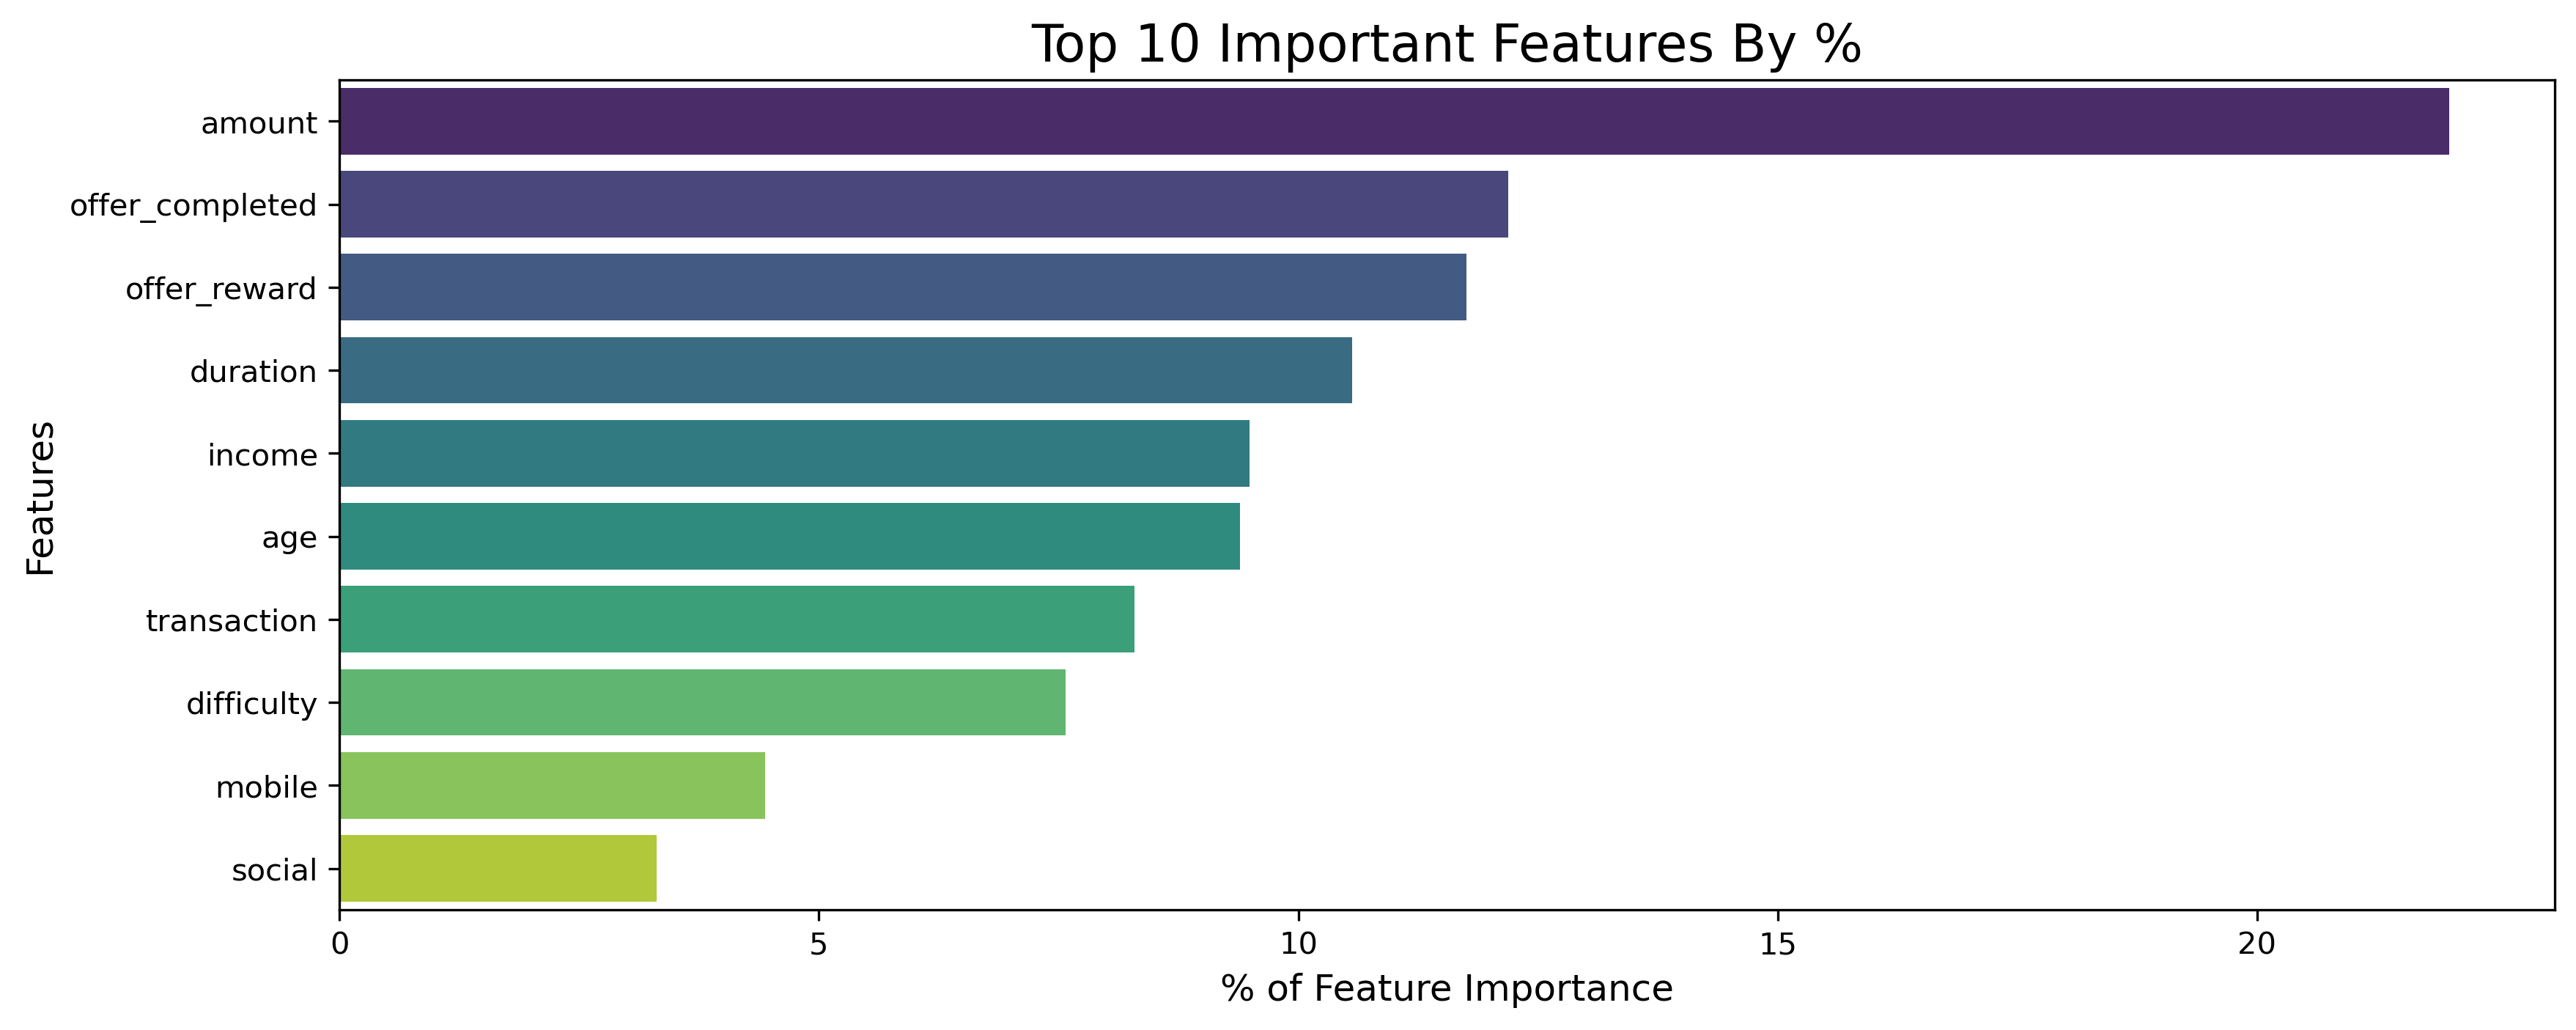

In [89]:
# Plot bar chart of features with their importance
plt.figure(figsize=[13,5], dpi = 300)
sns.barplot(x=feature_imp_rfc.loc[0:10,'feat_imp_rate'], y=feature_imp_rfc.loc[0:9,'feature'], palette = 'viridis', data=feature_imp_rfc)
plt.xlabel('% of Feature Importance', fontsize = 12)
plt.ylabel('Features', fontsize = 12)
plt.title('Top 10 Important Features By %', fontsize = 17)

plt.savefig('./screenshots/16_Top_10_Important_Features.png', dpi=600, bbox_inches ='tight')
plt.show()

### Predict test data using RandomForestClassifier

In [90]:
# Scale selected features in test data
X_test_scaled = features_scale(X_test, feat=features_to_scale)
X_test_scaled.head()

,offer_completed,transaction,amount,is_bogo,is_discount,mobile,social,web,gender_F,gender_M,gender_O,user_info_provided,offer_reward,duration,difficulty,age,income
20775,1,0,0.00,1.0,0.0,1.0,0.0,1.0,0,1,0,0,0.5,0.7,0.25,0.36,0.677778
17262,0,1,25.78,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0,0.00,0.42,0.266667
74905,0,1,3.46,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.00,0.20,0.155556
75796,0,1,1.52,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0.0,0.0,0.00,0.03,0.311111
22320,0,1,8.71,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,0.0,0.00,0.65,0.311111


In [91]:
# Classification of test data using best model trained on train data
y_pred_rf = rfc_best_est.predict(X_test_scaled)
y_pred_rf

array([1., 0., 0., ..., 1., 0., 0.])

### Data Modeling Using LinearSVC

In [92]:
# Scale selected features in training set i.e. X_train
X_train_scaled = features_scale(X_train, feat=features_to_scale)

In [93]:
# Scale selected features in test data
X_test_scaled = features_scale(X_test, feat=features_to_scale)

In [94]:
# ML Pipeline with grid search to tune the parameters
pipeline = Pipeline(
        [
            ("clf", LinearSVC(dual=False)),
        ]
    )
parameters = {"clf__C": [1, 100]}
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train_scaled, y_train);

### Predict test data using LinearSVC

In [95]:
y_pred_svc = cv.predict(X_test_scaled)

## Model Evaluation

We use the classification report from sklearn to evaluate the model.

### Model Evaluation for RandomForestClassifier

In [96]:
# Calculate confusion matrix
confusion_matrix(y_test.squeeze().values, y_pred_rf)

array([[26436,  1365],
       [ 2435,  4191]], dtype=int64)

In [97]:
# print classification_report
print(classification_report(y_test, y_pred_rf, target_names=['Customers Won\'t Respond','Customers Will Respond']))

                         precision    recall  f1-score   support

Customers Won't Respond       0.92      0.95      0.93     27801
 Customers Will Respond       0.75      0.63      0.69      6626

               accuracy                           0.89     34427
              macro avg       0.83      0.79      0.81     34427
           weighted avg       0.88      0.89      0.89     34427



Based on the model evaluation, the performance of our RandomForestClassifier model prediction is as follows

* Prediction for Customers who will most probably not respond to an offer is pretty good with a F1-score of 0.93.
* Prediction for Customers who will most probably respond to an offer is comparatively less with a F1-score of 0.69
* The average accuracy of the model is 0.89 which is pretty good.

In [98]:
# displaye tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, y_pred_rf).ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 26436
false postives: 1365
false negatives: 2435
true postives: 4191


In [99]:
# displaye tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, y_pred_rf, normalize = 'true').ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 0.9509010467249379
false postives: 0.04909895327506205
false negatives: 0.3674916993661334
true postives: 0.6325083006338665


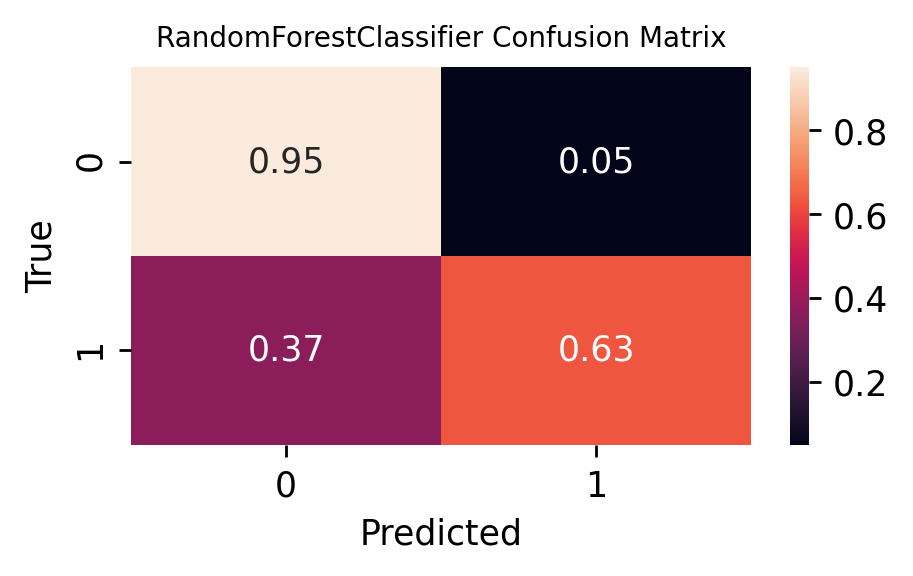

In [100]:
plt.figure(figsize=(4,2), dpi = 250)

sns.heatmap(confusion_matrix(y_test,y_pred_rf,  normalize = 'true'),annot=True,fmt='.2f')
plt.title("RandomForestClassifier Confusion Matrix", fontsize = 8)
plt.xlabel('Predicted')
plt.ylabel('True');


plt.savefig('./screenshots/17_Confusion_Matrix_RF_.png', dpi=600, bbox_inches ='tight')
plt.show()

### Data Modeling Using LinearSVC

In [101]:
# Calculate confusion matrix
confusion_matrix(y_test.squeeze().values, y_pred_svc)

array([[26262,  1539],
       [ 2218,  4408]], dtype=int64)

In [102]:
print(classification_report(y_test, y_pred_svc, target_names=['Customers Won\'t Respond','Customers Will Respond']))

                         precision    recall  f1-score   support

Customers Won't Respond       0.92      0.94      0.93     27801
 Customers Will Respond       0.74      0.67      0.70      6626

               accuracy                           0.89     34427
              macro avg       0.83      0.80      0.82     34427
           weighted avg       0.89      0.89      0.89     34427



Based on the model evaluation, the performance of our lLinear SVC model prediction is as follows

* Prediction for Customers who will most probably not respond to an offer is pretty good with a F1-score of 0.93.
* Prediction for Customers who will most probably respond to an offer is comparatively less with a F1-score of 0.70
* The average accuracy of the model is 0.89 which is pretty good.

In [103]:
# displaye tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, y_pred_svc).ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 26262
false postives: 1539
false negatives: 2218
true postives: 4408


In [105]:
# displaye tn, fp, fn, tp from confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test.squeeze().values, y_pred_svc, normalize = 'true').ravel()
print('true negatives: {}'.format(tn))
print('false postives: {}'.format(fp))
print('false negatives: {}'.format(fn))
print('true postives: {}'.format(tp))

true negatives: 0.9446422790547102
false postives: 0.055357720945289735
false negatives: 0.334741925747057
true postives: 0.6652580742529429


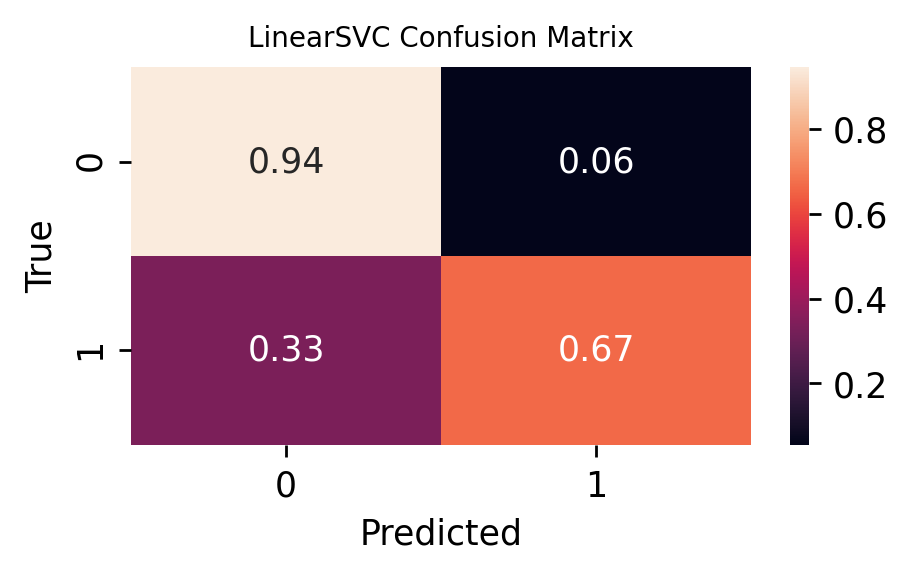

In [106]:
plt.figure(figsize=(4,2), dpi = 250)

sns.heatmap(confusion_matrix(y_test,y_pred_svc,  normalize = 'true'),annot=True,fmt='.2f')
plt.title("LinearSVC Confusion Matrix", fontsize = 8)
plt.xlabel('Predicted')
plt.ylabel('True');


plt.savefig('./screenshots/18_Confusion_Matrix_LinearSVC_.png', dpi=600, bbox_inches ='tight')
plt.show()

## Justification

Based on the analysis and exploration done, how customer demographics and the offer reward affect user response to offers or advertisements sent are identified in this project. 

First, we identified users for whom there are demographic information was missing, and we classified them into a separate group. There are 13% of the total users who have prefered not to share their personal info. This helped us identify accurately the gender distribution in the dataset. We saw that males take up 57% of total users and females take up 41%, leaving 1% for others.

Next we observed that the majority of users are in their late 50's or eary 60's, and that the number of users decreases as we move away from the peak. And age doesn't affect the user attraction towards certain offer rewards. However, it was seen that the average amount spent per transaction increases as user age increases.

Many users have an annual income in the range between 30000 USD and 50000 USD, but the majority are in the range between 50000 USD and 75000 USD, and of course less users have high annual salary. The amount spent per transaction is more when the user income is more, which is expected.

After that we saw that 75% of all the received offers were actually viewed, and that 71% of users complete offers after they view them leaving 29% completing offers unintentionally.

It was seen that offers influence 19% of the total transactions or completed offers that occured, which is pretty big, and that users are 7% more likely to respond to offers when they are sent through social media.

We saw how gender plays role in the average amount spent by a user, and also in responding to which type of offer reward. Males responded more to the 2, 3, and 5 dollar rewards while females respond more to the 10 dollar rewards, and on average, females spend more than males.

People who chose to stay anonymous tend to spend more per transaction in the group that responded to offers, however, for the other group it's completely the opposite, known users spend a lot more than anonymous users.

Finally, we built a model that predicts whether a user will respond to an offer or not based of demographics and offer reward, and the model predicted this with an accuracy of 87%, a F1-score of 0.65 for identifing those who will repond to offers, and an F1-score of 0.92 for those who won't.

## Conclusion

### Reflection

The problem that I chose to solve as part of this project is to build a model that predicts whether a customer will respond to an offer or not. The approach being used for solving this problem has mainly three steps. 

* First, after preprocessing portfolio, profile and transaction datasets, data sets were combined to get a final clean data containing relevant features which can be used to train our model.

* Second, After splitting data to train and test datasets, we choose the modelling techinqies "RandomForestClassifier" and LinearSVC with GridSearch classifier algorithms. 

* Third, we predicted the test target using test data, and plot a confusion matrix to evaluate the prformance of our model. There is not much difference the way both the models performing as the f1-score and model accuracy is almost the same for both the models.

The most interesting aspect of this project is the combination between different datasets, using predictive modeling techniques and analysis to provide better decisions and value to the business. The data exploration and wrangling steps were the longest and most challenging part. The toughest part of this entire analysis was to find right logic and strategy to answer the problem statements and conveying them with different visualization techniques.


### Improvement

* Better predictions may have been deducted if there were more customer metrics available. For this analysis, I believe there are limited information available about customers which is just age, gender, and income. To find optimal customer demographics, it would be nice to have a few more features of a customer. These additional features may aid in providing better classification model results data in order to have more better model.


* To improve prediction results, we can consider increasing the data size by collecting data over a larger period of time. In this project, the data was collected over a period of one month, but it's not clear from which day the experiment started, some people may pay more in the start of the month than they would at the end because of salary dependecies. So collecting data over 3 months or more would produce a big improvement in the prediction results. Additionaly, after merged the data sets and removed duplicate entries, the data got even less records. So With more data, the classification models may have been able to produce better F1-score results.

In [107]:
import os
os.system('jupyter nbconvert --to html Starbucks_Capstone_notebook.ipynb')

0